## **1.0 INTRODUCTION**

As Malaysia continues to advance in digital healthcare and public health surveillance, data-driven insights have become increasingly vital in managing and mitigating the spread of infectious diseases. The COVID-19 pandemic has highlighted the urgent need for robust data management, analysis, and visualization techniques to support real-time decision-making and resource allocation in the healthcare sector. Similarly, the rising prevalence of other infectious diseases such as sexually transmitted diseases (STDs) poses significant public health challenges that require timely monitoring and intervention.

### **1.1 PROBLEM STATEMENT** 

Infectious diseases continue to present major health concerns in Malaysia, especially in the wake of the COVID-19 pandemic. Despite the availability of large volumes of health-related data, there exists a gap in transforming these raw datasets into meaningful insights that can drive policy and public health decisions. Specifically, there is a need to explore how the trends of COVID-19 and sexually transmitted diseases have evolved across different regions and time periods in Malaysia.

### **1.2 OBJECTIVES**

This study aims to uncover patterns, identify hotspots, and generate actionable insights that can inform healthcare planning, disease prevention, and public awareness initiatives. 

## **2.0 DATA COLLECTION**

The datasets was retrieved from open-access healthcare data from [Data.gov.my](https://data.gov.my/), focusing on infectious disease statistics across Malaysia, particularly COVID-19 and STD cases. Through effective data preprocessing using Hadoop System (Apache Hive), visualization, and interpretation, this project underscores the critical role of data management in shaping public health strategies and outcomes. The datasets include:

1. COVID-19 cases : COVID-19 cases includes new cases, imported cases and recovered cases across Malaysia from 2020 to 2025 (https://data.gov.my/data-catalogue/covid_cases).

   This raw dataset consists of variables:
- `date` (*Date*) - Date in YYYY-MM-DD format
- `state` (*State*) - One of 16 states, or Malaysia
- `cases_new` (*New Cases*) - Number of new cases reported in the 24 hours since the last report; note that this is based on the date of report and not the date of the test.
- `cases_import` (*Imported Cases*) - Number of new cases imported from abroad, i.e. inviduals who were infected outside the country
- `cases_recovered` (*Recoveries*) - Number of recoveries from COVID-19 reported in the 24 hours since the last report
- `cases_active` (*Active Cases*) - Number of COVID-19 cases who have not recovered or died
- `cases_cluster` (*Cluster-related Cases*) - Number of cases attributable to clusters; the difference between new cases and the sum of cases attributable to clusters is the number of sporadic cases

2. Sexually Transmitted Diseases (STDs) cases: STDs cases such as AIDS, HIV, chancroid, gonorrhea, syphillis cases across from 2017 to 2022 (https://data.gov.my/data-catalogue/std_state).

   This raw dataset consists of variables:
- `date` (*Date*) - The date in YYYY-MM-DD format, with MM-DD set to 01-01 as the data is at annual frequency.
- `state` (*State*) - One of 16 states, or Malaysia; data for W.P. Putrajaya is subsumed under W.P. Kuala Lumpur.
- `disease` (*Disease*) - The type of sexually transmitted disease (STD).
- `case` (*Cases*) - Number of reported cases, classified based on the date of report.
- `incidence` (*Incidence*) - Incidence rate per 100,000 population in the state.

## **3.0 DATA PREPROCESSING** 

In this stage, the apache hive was used for preprocessing such as aggregating the value, re-formating the date to ensure the standardization and can be further analyse through visualization 

### **3.1 Load All Necessary Libraries**

In [1]:
#Import necessary libraries
import pandas as pd #for data manipulation
from impala.dbapi import connect #connecting with Apache Hive 
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns #for data visualization
import geopandas as gpd #for mapping data

import warnings #for ignoring unrelevant ouput notifications
warnings.filterwarnings("ignore", category=FutureWarning)

### **3.2 Connecting to Hive Database**

The STDs and COVID-19 dataset was uploaded in the Hive database 'foodmart' via VirtualBox Machine and linked with juypter notebook with custom python environment for querying data.

#### **3.2.1 Pivoting STDs Dataset using Apache Hive**

The STDs dataset was preprocessed by re-formatting the date as year only and the number of cases and incidence was grouped by year, state and disease by aggregate using average functions. The dataset was sorted by year in ascending order. 

In [2]:
# Establish connection
conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='foodmart',
    auth_mechanism='PLAIN'
)

cursor = conn.cursor()

# Query for STDs dataset to be pulled from Apache Hive, the data was pivoted, grouped by year, state and disease
query = '''
SELECT 
    year(record_date) AS year,
    state,
    disease,
    AVG(cases) AS avg_cases,
    AVG(incidence) AS avg_incidence
FROM std_state
GROUP BY year(record_date), state, disease
ORDER BY year, state, disease
'''

# Execute query
cursor.execute(query)

# Fetch data and column names
data = cursor.fetchall()
columns = [col[0] for col in cursor.description]

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Preview results
df.head(10)

,year,state,disease,avg_cases,avg_incidence
0,2017,Johor,aids,178.0,4.72
1,2017,Johor,chancroid,1.0,0.03
2,2017,Johor,gonorrhea,404.0,10.72
3,2017,Johor,hiv,347.0,9.20
4,2017,Johor,syphillis,295.0,7.82
5,2017,Kedah,aids,40.0,1.84
6,2017,Kedah,chancroid,0.0,0.00
7,2017,Kedah,gonorrhea,118.0,5.42
8,2017,Kedah,hiv,187.0,8.60
9,2017,Kedah,syphillis,83.0,3.82


In [3]:
#The information of the STDs dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           480 non-null    int64  
 1   state          480 non-null    object 
 2   disease        480 non-null    object 
 3   avg_cases      480 non-null    float64
 4   avg_incidence  480 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.9+ KB


After the data has been preprocessed, there are total of 480 records of observation with 5 variables for STDs cases.

#### **3.2.2 Pivoting COVID-19 Dataset using Apache Hive**

The COVID-19 dataset was preprocessed by re-formating the date as year only, the number of new, imported, recovered and active cases was grouped by year by aggregating using average functions. The dataset was ordered by year in ascending order.

In [4]:
# Establish connection
conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='foodmart',
    auth_mechanism='PLAIN'
)

cursor2 = conn.cursor()

# Query for COVID-19 dataset to be pulled from Apache Hive, the data was pivoted, grouped by year, state and disease
query2 = '''
SELECT 
    YEAR(record_date) AS year,
    state,
    AVG(cases_new) AS avg_new_cases,
    AVG(cases_import) AS avg_import_cases,
    AVG(cases_recovered) AS avg_cases_recovered,
    AVG(ABS(cases_active)) AS avg_active_cases
FROM covid_cases
GROUP BY YEAR(record_date), state
ORDER BY year
'''

# Execute query
cursor2.execute(query2)

# Fetch data and column names
data2 = cursor2.fetchall()
columns2 = [col[0] for col in cursor2.description]

# Create DataFrame
covid_cases = pd.DataFrame(data2, columns=columns2)

# Preview results
covid_cases.head(10)

,year,state,avg_new_cases,avg_import_cases,avg_cases_recovered,avg_active_cases
0,2020,Kedah,8.842105,0.052632,8.400585,118.394737
1,2020,Kelantan,2.216374,0.055556,1.453216,21.374269
2,2020,Malaysia,330.438596,6.061404,260.058480,3520.342105
3,2020,Melaka,3.581871,0.263158,1.959064,38.000000
4,2020,Negeri Sembilan,22.888889,0.675439,20.780702,216.847953
5,2020,Pahang,3.991228,0.064327,2.461988,45.464912
6,2020,Perak,9.342105,0.090643,8.429825,81.783626
7,2020,Perlis,0.134503,0.011696,0.125731,2.336257
8,2020,Johor,16.766082,0.418129,8.257310,176.783626
9,2020,Pulau Pinang,10.198830,0.049708,8.900585,77.669591


In [5]:
#Retrieving information of COVID-19 dataset 
covid_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 102 non-null    int64  
 1   state                102 non-null    object 
 2   avg_new_cases        102 non-null    float64
 3   avg_import_cases     102 non-null    float64
 4   avg_cases_recovered  102 non-null    float64
 5   avg_active_cases     102 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.9+ KB


After the data has been preprocessed, there are total of 102 records of obvservation with 6 variables for COVID-19 cases.

## **4.0 DATA VISUALIZATION**

Data visualization was conducted in order to identify patterns and trends for COVID-19 and STDs cases in Malaysia. Several type of visualisation was used including scatterplot, bar charts and demographic visualisation in identifying hotspots or critical area in Malaysia that needs to be highlighted. 

### **4.1 COVID-19 Cases in Malaysia by Year**

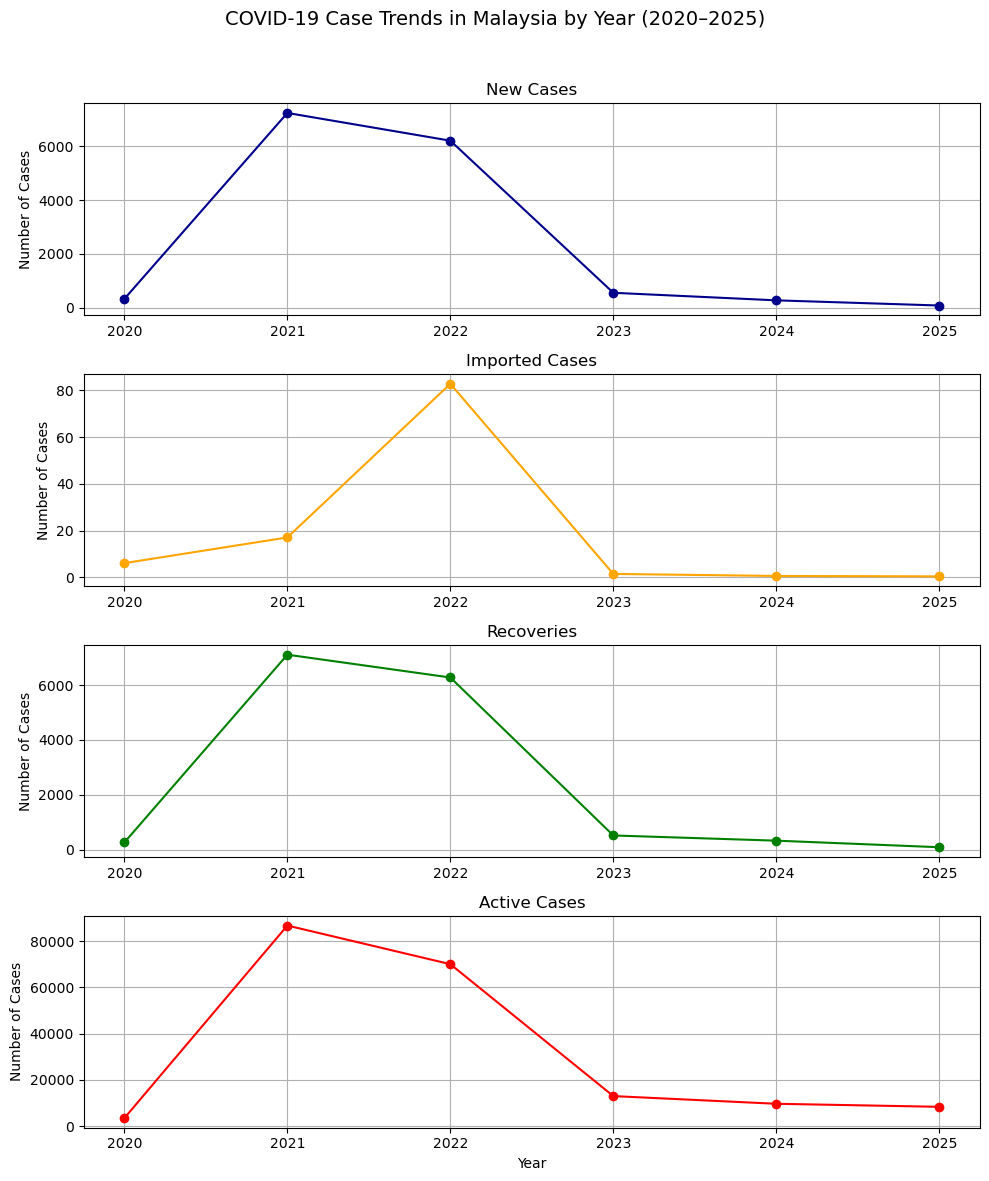

In [6]:
# Filter only for Malaysia
df_malaysia = covid_cases[covid_cases['state'] == 'Malaysia'].sort_values(by='year')

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=False)

# Plot each variable
axs[0].plot(df_malaysia['year'], df_malaysia['avg_new_cases'], marker='o', color='darkblue')
axs[0].set_title('New Cases')

axs[1].plot(df_malaysia['year'], df_malaysia['avg_import_cases'], marker='o', color='orange')
axs[1].set_title('Imported Cases')

axs[2].plot(df_malaysia['year'], df_malaysia['avg_cases_recovered'], marker='o', color='green')
axs[2].set_title('Recoveries')

axs[3].plot(df_malaysia['year'], df_malaysia['avg_active_cases'], marker='o', color='red')
axs[3].set_title('Active Cases')

# Common labels and ticks
for ax in axs:
    ax.grid(True)
    ax.set_ylabel('Number of Cases')

# Set x-ticks for all years from 2020 to 2025
axs[-1].set_xticks([2020, 2021, 2022, 2023, 2024, 2025])
axs[-1].set_xlabel('Year')

# Add main title
fig.suptitle('COVID-19 Case Trends in Malaysia by Year (2020–2025)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The figure illustrates the trend of COVID-19 cases in Malaysia from 2020 to 2025, represented by the average number of new cases, imported cases, recovered cases, and active cases. The trend can be broadly categorized into three distinct phases, each corresponding to the stages of pandemic response, viral evolution, and public health interventions.

During the first phase (2020–2021), the number of average new, recovered, and active COVID-19 cases increased exponentially. This period marked the onset of the pandemic in Malaysia, during which SARS-CoV-2 spread rapidly. The surge in new and active cases can be attributed to limited scientific knowledge of the virus, lack of vaccines, and delayed implementation of containment strategies. Highly transmissible variants such as Alpha and Delta exacerbated the situation, leading to widespread community transmission (World Health Organization, 2020; Lai et al., 2020). The increase in recoveries during this period also reflects the rising number of infected individuals and the scaling up of testing and healthcare response.

The second phase (2021–2023) is characterized by a gradual decline in all case categories particularly new, active, and imported cases. The reduction is closely linked to the launch of Malaysia’s National COVID-19 Immunisation Programme in early 2021, which expanded vaccine coverage nationwide (Ministry of Health Malaysia, 2022). In addition, public health measures such as mobility restrictions, face mask mandates, and booster vaccinations contributed to reduced virus transmission and fewer severe cases. The declining trend in active cases highlights the impact of widespread immunity and the reduced burden on healthcare systems (Tan et al., 2023).

The third phase (2023–2025) marks the transition of COVID-19 into an endemic stage. The consistently low and stabilizing trends in new, active, and imported cases during this period indicate that Malaysia had achieved broad population-level immunity through both vaccination and natural infection, known as hybrid immunity (Kwok et al., 2020). Enhanced healthcare readiness, ongoing surveillance, and access to antiviral treatments such as Paxlovid played a significant role in maintaining low case numbers. While the virus continued to circulate, its public health impact was substantially reduced, allowing for the gradual lifting of restrictions and border reopening with minimal resurgence in active cases.

**References:**

Kwok, K. O., Lai, F., Wei, W. I., Wong, S. Y. S., & Tang, J. W. (2020). Herd immunity–estimating the level required to halt the COVID-19 epidemics in affected countries. Journal of Infection, 80(6), e32-e33.

Lai, C. C., Shih, T. P., Ko, W. C., Tang, H. J., & Hsueh, P. R. (2020). Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) and coronavirus disease-2019 (COVID-19): The epidemic and the challenges. International journal of antimicrobial agents, 55(3), 105924.

Ministry of Health Malaysia. (2022). COVIDNOW: National COVID-19 Immunisation Programme. Retrieved from https://covidnow.moh.gov.my/

Tan, S. T., Kwan, A. T., Rodríguez-Barraquer, I., Singer, B. J., Park, H. J., Lewnard, J. A., ... & Lo, N. C. (2023). Infectiousness of SARS-CoV-2 breakthrough infections and reinfections during the Omicron wave. Nature Medicine, 29(2), 358-365.

World Health Organization (WHO). (2020). Coronavirus disease (COVID-19) pandemic. Retrieved from https://www.who.int/emergencies/diseases/novel-coronavirus-2019

### **4.2 COVID-19 Cases in Malaysia by State**

#### **4.2.1 New COVID-19 Cases by State (2020 - 2025)**

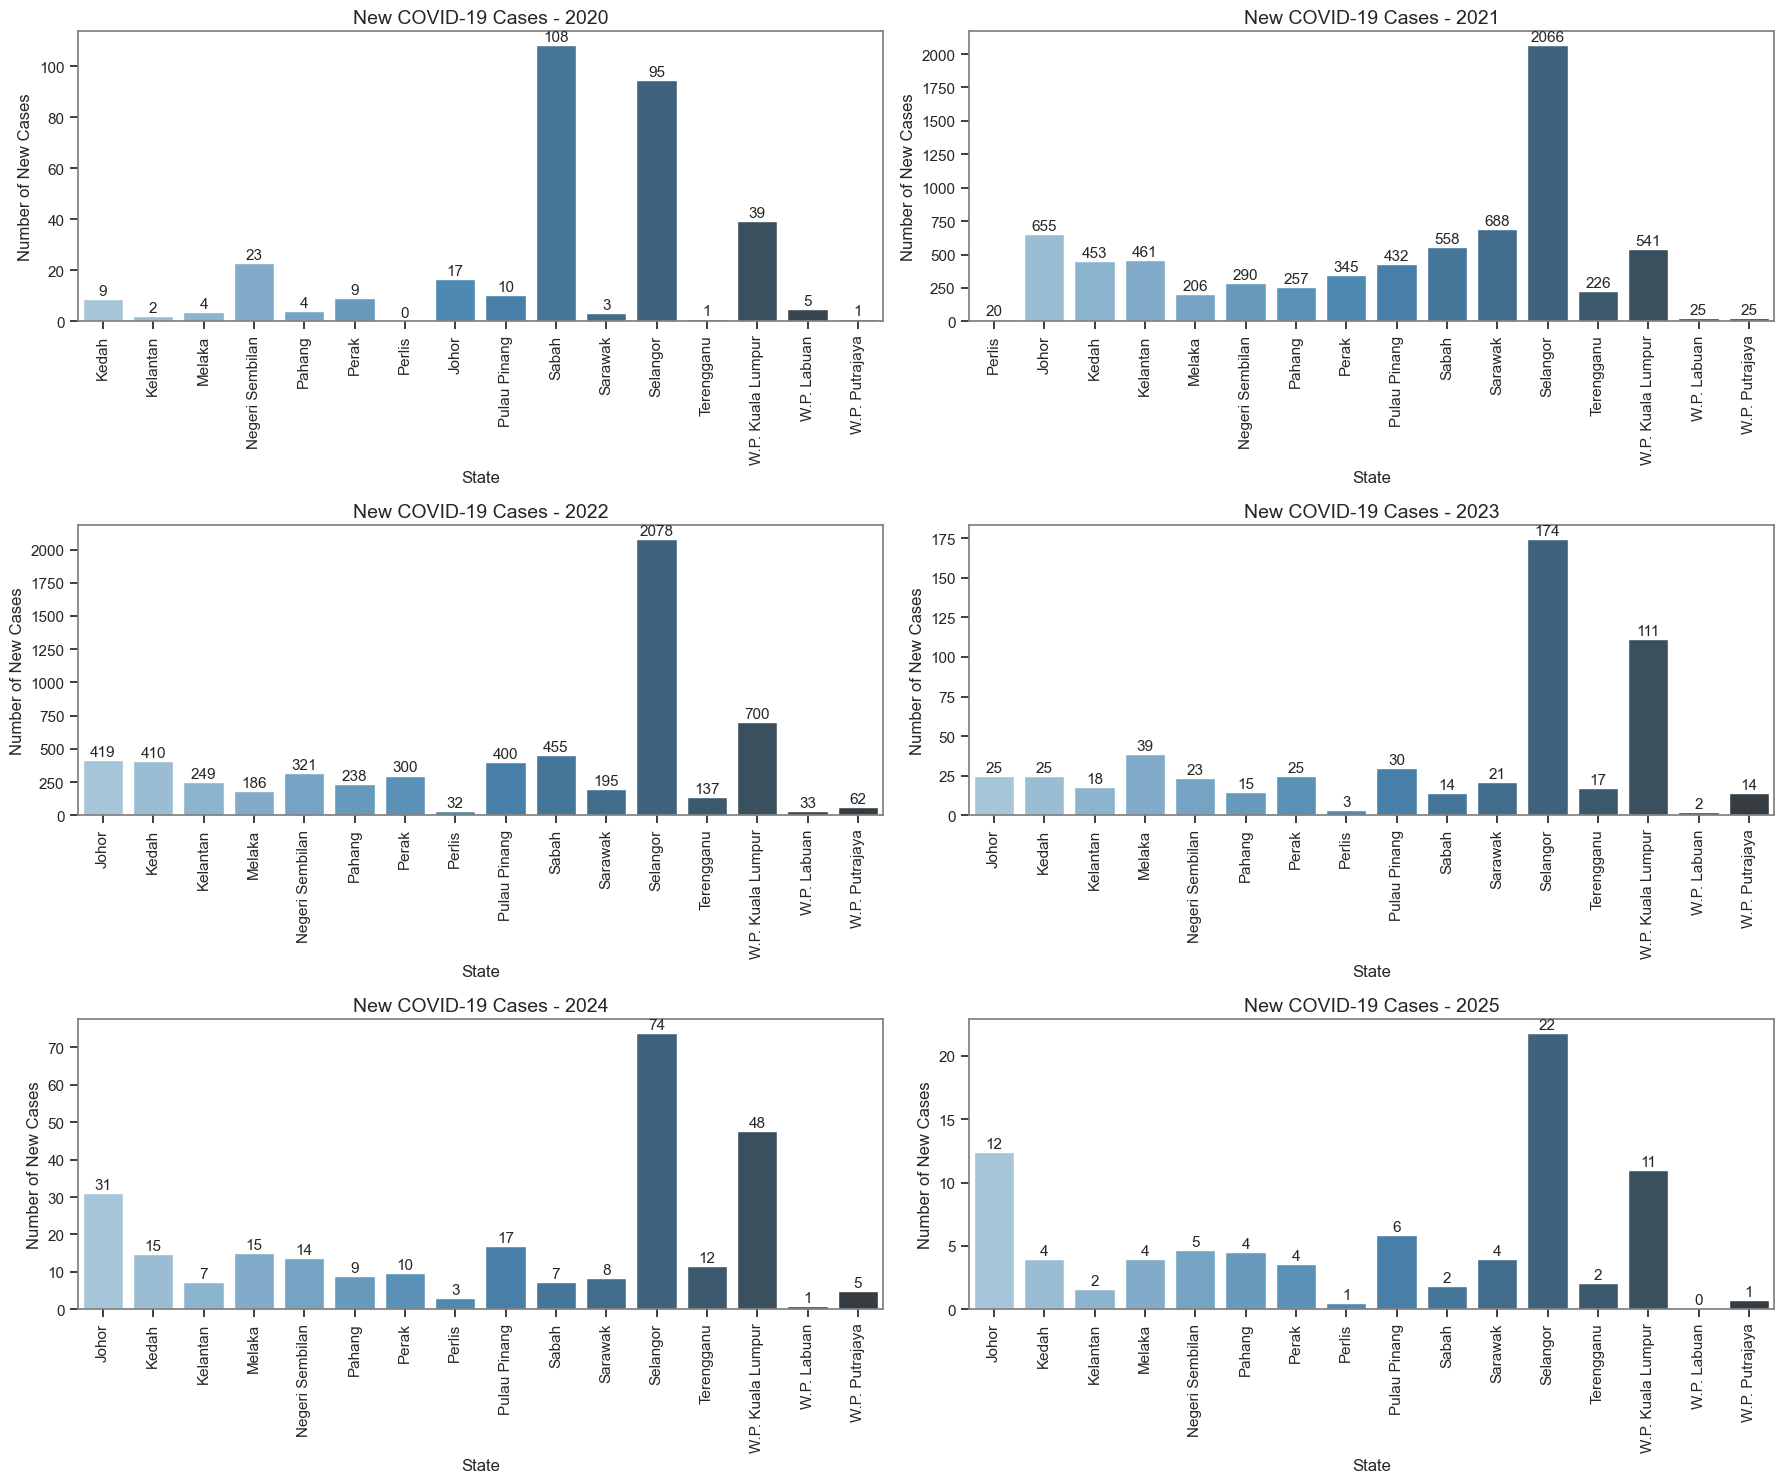

In [7]:
#filter rows excluding Malaysia observation
df_malaysia = covid_cases[covid_cases['state'] != 'Malaysia']

# Ensure consistent style
sns.set(style="ticks")

# Define the years to visualize
years = [2020, 2021, 2022, 2023, 2024, 2025]

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

# Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = df_malaysia[df_malaysia['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_new_cases',
        ax=ax,
        palette='Blues_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'New COVID-19 Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of New Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

# Adjust layout
plt.tight_layout()
plt.show()


The figure above presents a comprehensive overview of the average number of new COVID-19 cases across Malaysian states from 2020 to 2025. In 2020, the COVID-19 pandemic began to significantly impact Malaysia, with states such as Sabah, Selangor, W.P. Kuala Lumpur, and Negeri Sembilan recording notably higher average daily cases compared to others. These regions are among the most densely populated and urbanized areas in Malaysia, which could have contributed to the higher transmission rates due to increased population mobility, urban crowding, and socioeconomic activities (Aw et al., 2021; Iderus et al., 2022).

In 2021, there was a stark increase in the number of average daily COVID-19 cases across almost all states, with Selangor reaching a peak of 2,066 cases, the highest in the country. This surge corresponds with the emergence of more transmissible variants of concern, such as the Delta variant, which had significantly higher rates of transmission and virulence. Additionally, 2021 was marked by the healthcare system's increasing burden, particularly in urban centers like Selangor and Kuala Lumpur, which serve as economic and administrative hubs (Ministry of Health Malaysia, 2021). The continued rise in 2022, with Selangor again registering the highest average at 2,078 cases, can be attributed to the residual impact of the Delta wave and the later emergence of the Omicron variant, which, while less severe, was highly transmissible (World Health Organization [WHO], 2022).

However, from 2023 onwards, the graphs illustrate a substantial decline in the average number of new cases across all states. This trend can be strongly associated with the widespread rollout and uptake of COVID-19 vaccines in Malaysia beginning mid-2021. Vaccination significantly reduced severe illness and transmission rates. By 2023, booster doses were also introduced, and Malaysia achieved high coverage among vulnerable populations, contributing to community immunity (Wong et al., 2023). Public health interventions, increased testing, contact tracing, and public compliance with standard operating procedures further played key roles in the containment of the virus. By 2025, all states recorded a minimal number of new daily cases, with Selangor, which had previously led in case numbers, now recording an average of just 22 new cases, indicating strong control over community spread.

In conclusion, the observed pattern in the graph reflects the natural course of the pandemic exacerbated by virus mutations and mitigated through robust public health responses, especially mass vaccination campaigns. The data highlights the importance of early interventions, health infrastructure readiness, and public cooperation in combating pandemics.

**References:**

Wong, M. T. J., Dhaliwal, S. S., Balakrishnan, V., Nordin, F., Norazmi, M. N., & Tye, G. J. (2023). Effectiveness of Booster Vaccinations on the Control of COVID-19 during the Spread of Omicron Variant in Malaysia. International Journal of Environmental Research and Public Health, 20(2), 1647. https://doi.org/10.3390/ijerph20021647

Ministry of Health Malaysia. (2021). COVID-19 Malaysia updates. Retrieved from https://covid-19.moh.gov.my/

Aw, S. B., Teh, B. T., Ling, G. H. T., Leng, P. C., Chan, W. H., & Ahmad, M. H. (2021). The COVID-19 Pandemic Situation in Malaysia: Lessons Learned from the Perspective of Population Density. International Journal of Environmental Research and Public Health, 18(12), 6566. https://doi.org/10.3390/ijerph18126566

Md Iderus, N. H., Lakha Singh, S. S., Mohd Ghazali, S., Yoon Ling, C., Cia Vei, T., Md Zamri, A. S. S., Ahmad Jaafar, N., Ruslan, Q., Ahmad Jaghfar, N. H., & Gill, B. S. (2022). Correlation between Population Density and COVID-19 Cases during the Third Wave in Malaysia: Effect of the Delta Variant. International Journal of Environmental Research and Public Health, 19(12), 7439. https://doi.org/10.3390/ijerph19127439

World Health Organization. (2022). Weekly epidemiological update on COVID-19 – 1 March 2022. Retrieved from https://www.who.int/publications/m/item/weekly-epidemiological-update-on-covid-19---1-march-2022


#### **4.2.2 Imported COVID-19 Cases By State (2020 - 2025)**

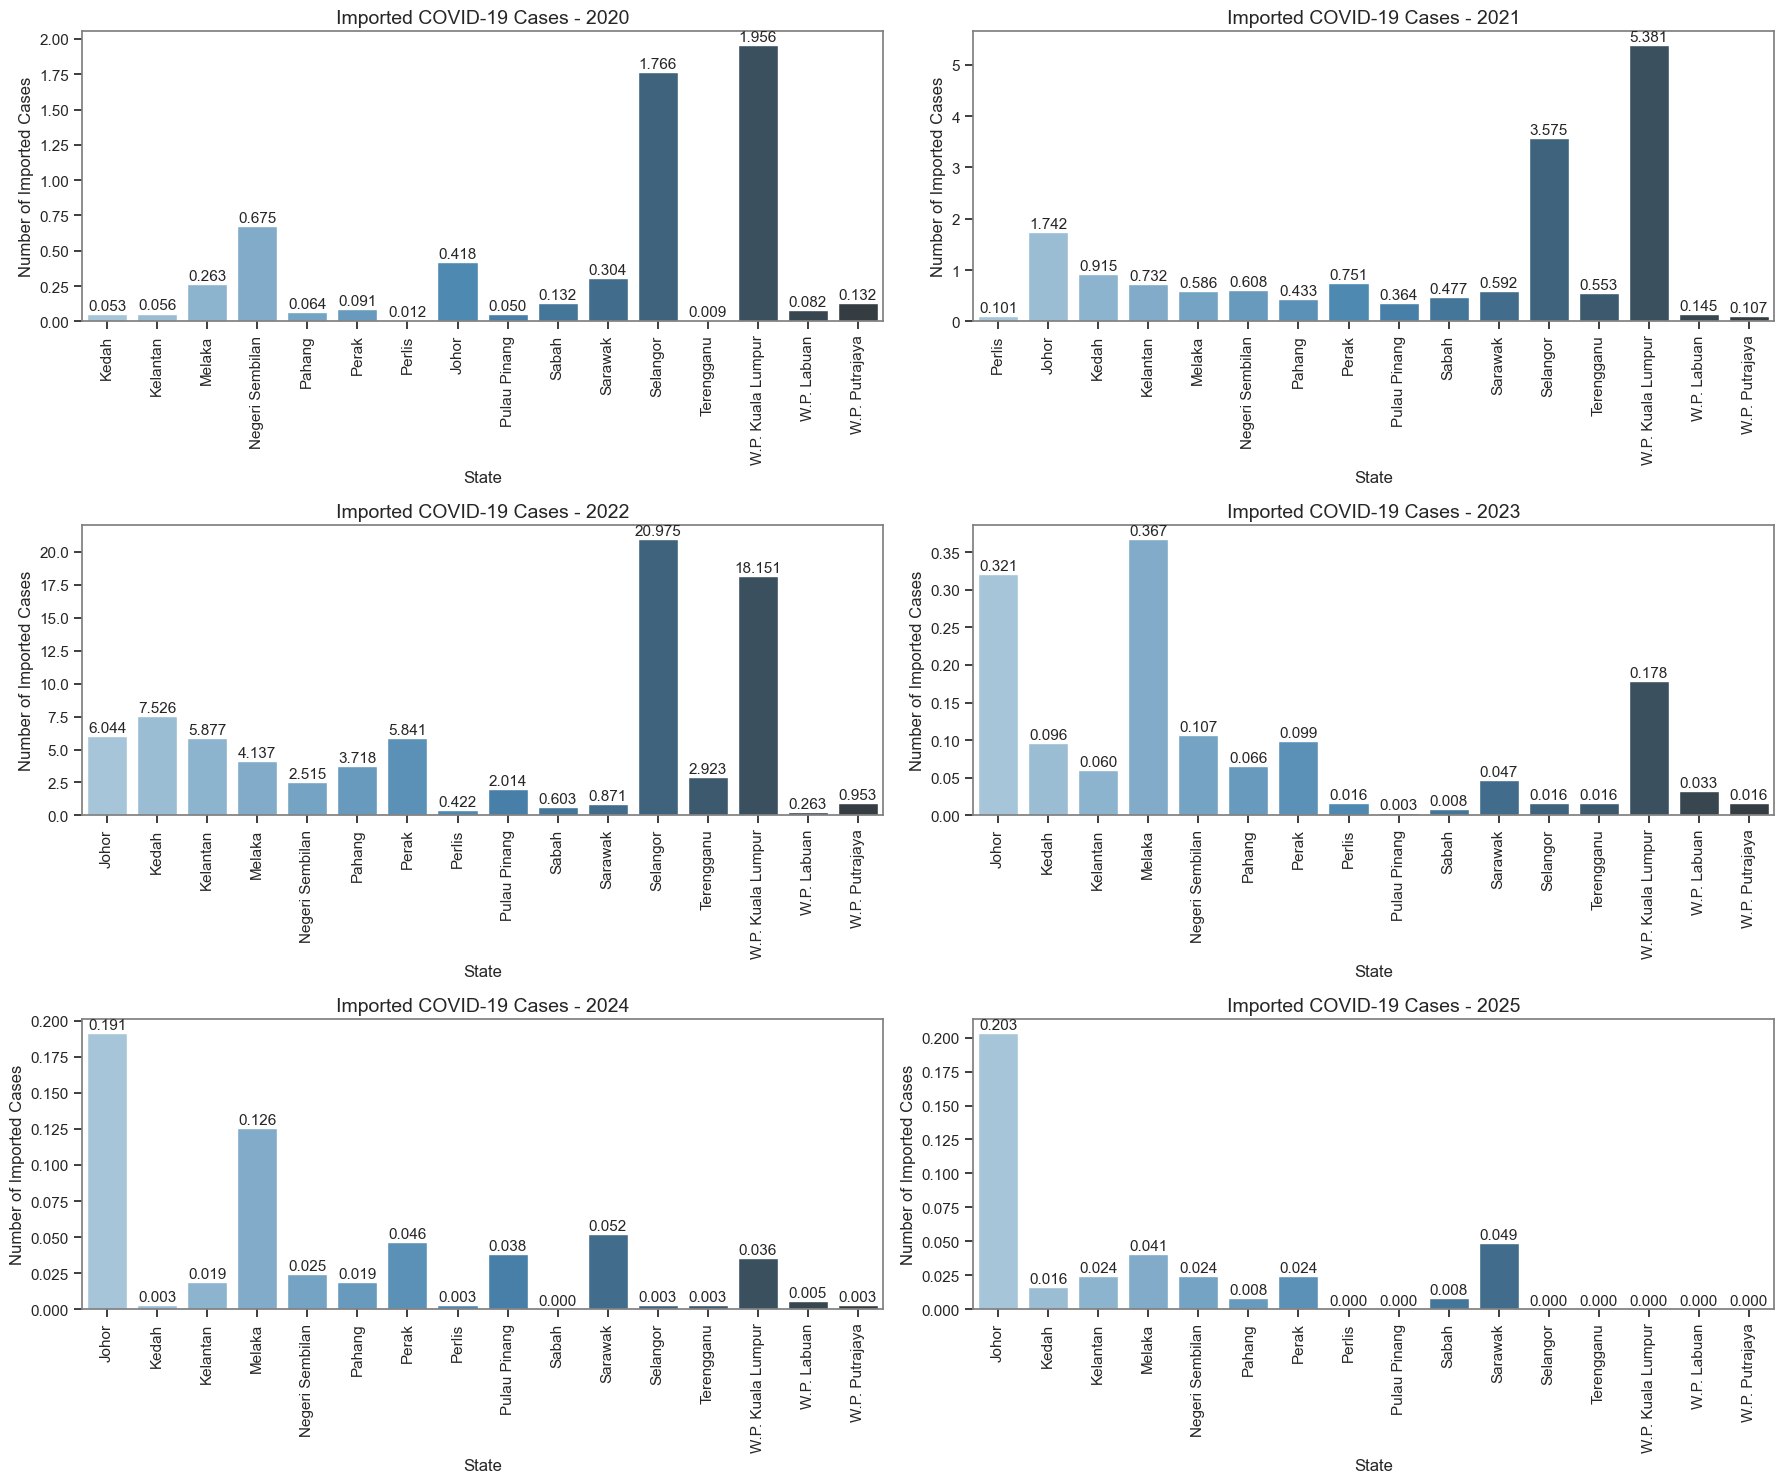

In [8]:
# Ensure consistent style
sns.set(style="ticks")

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

## Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = df_malaysia[df_malaysia['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_import_cases',
        ax=ax,
        palette='Blues_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.3f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'Imported COVID-19 Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Imported Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')


# Adjust layout
plt.tight_layout()
plt.show()

The data illustrated in the figure on imported COVID-19 cases across Malaysian states from 2020 to 2025 highlights a relatively lower magnitude of cases compared to new local transmissions within the country. In 2020, when international borders were still relatively open during the early stages of the pandemic, a number of imported cases were recorded, particularly in key urban and entry point states such as Selangor, Sabah, and W.P. Kuala Lumpur, with W.P. Kuala Lumpur registering the highest average of 1.956 cases per day. This trend aligns with the fact that Kuala Lumpur serves as a major international travel hub, housing the country's largest international airport, Kuala Lumpur International Airport (KLIA) (Department of Statistics Malaysia, 2020).

In 2021, despite increased border restrictions, there was a noticeable rise in imported cases in several states, with W.P. Kuala Lumpur (5.381) and Selangor (3.575) continuing to top the chart. This increase can be associated with the repatriation of citizens, return of expatriates, and travelers arriving for essential purposes, even amidst stringent Standard Operating Procedures (SOPs) such as mandatory quarantine and testing (Ministry of Health Malaysia, 2021). By 2022, the number of imported cases surged, particularly in Selangor (20.975), W.P. Kuala Lumpur (18.151), and Kedah (7.526). This spike may be attributed to the gradual reopening of international borders and the resumption of travel following the widespread administration of vaccines and improved global health measures. The influx of travelers and international mobility significantly contributed to this temporary rise in imported cases (World Health Organization [WHO], 2022).

However, from 2023 onwards, a marked decline in imported cases is observed, continuing into 2024 and 2025. For example, in 2025, all states recorded an average of fewer than 0.05 imported cases daily, with many states such as Terengganu and W.P. Labuan recording zero. This downward trend reflects the effectiveness of ongoing travel protocols, such as health screenings at points of entry, vaccination mandates for travelers, and declining global infection rates. Additionally, by this period, international travel patterns had not fully returned to pre-pandemic levels, which contributed to the reduction in imported cases (Kamaruzaman et al., 2025; Wong et al., 2023).

In conclusion, while imported COVID-19 cases played a role in the initial seeding of the virus within Malaysia, especially in urban and internationally connected states, their overall impact remained minimal compared to the spread of new local cases. The containment of imported cases was largely successful due to the government's early and sustained focus on border control, quarantine enforcement, and public health surveillance measures.

**References:**

Department of Statistics Malaysia. (2020). Migration Survey Report, Malaysia, 2020. Retrieved from https://www.dosm.gov.my/portal-main/release-content/migration-survey-report-malaysia-2020

Wong, M. T. J., Dhaliwal, S. S., Balakrishnan, V., Nordin, F., Norazmi, M. N., & Tye, G. J. (2023). Effectiveness of Booster Vaccinations on the Control of COVID-19 during the Spread of Omicron Variant in Malaysia. International Journal of Environmental Research and Public Health, 20(2), 1647. https://doi.org/10.3390/ijerph20021647

Kamaruzaman, N. K., Duong, H., Ong‐Lim, A. L., Tran, L. P., Vu, H. H., Doungngern, P., ... & Attwell, K. (2025). COVID‐19 Vaccine Mandates in Southeast Asia: A Comparative Study of Policies in Malaysia, the Philippines, Thailand, and Vietnam. World Medical & Health Policy.

Ministry of Health Malaysia. (2021). COVID-19 Malaysia updates. Retrieved from https://covid-19.moh.gov.my/

World Health Organization. (2022). Global epidemiological update: COVID-19 and international travel. Retrieved from https://www.who.int/publications

#### **4.2.3 Recovered COVID-19 Cases By State (2020 - 2025)**

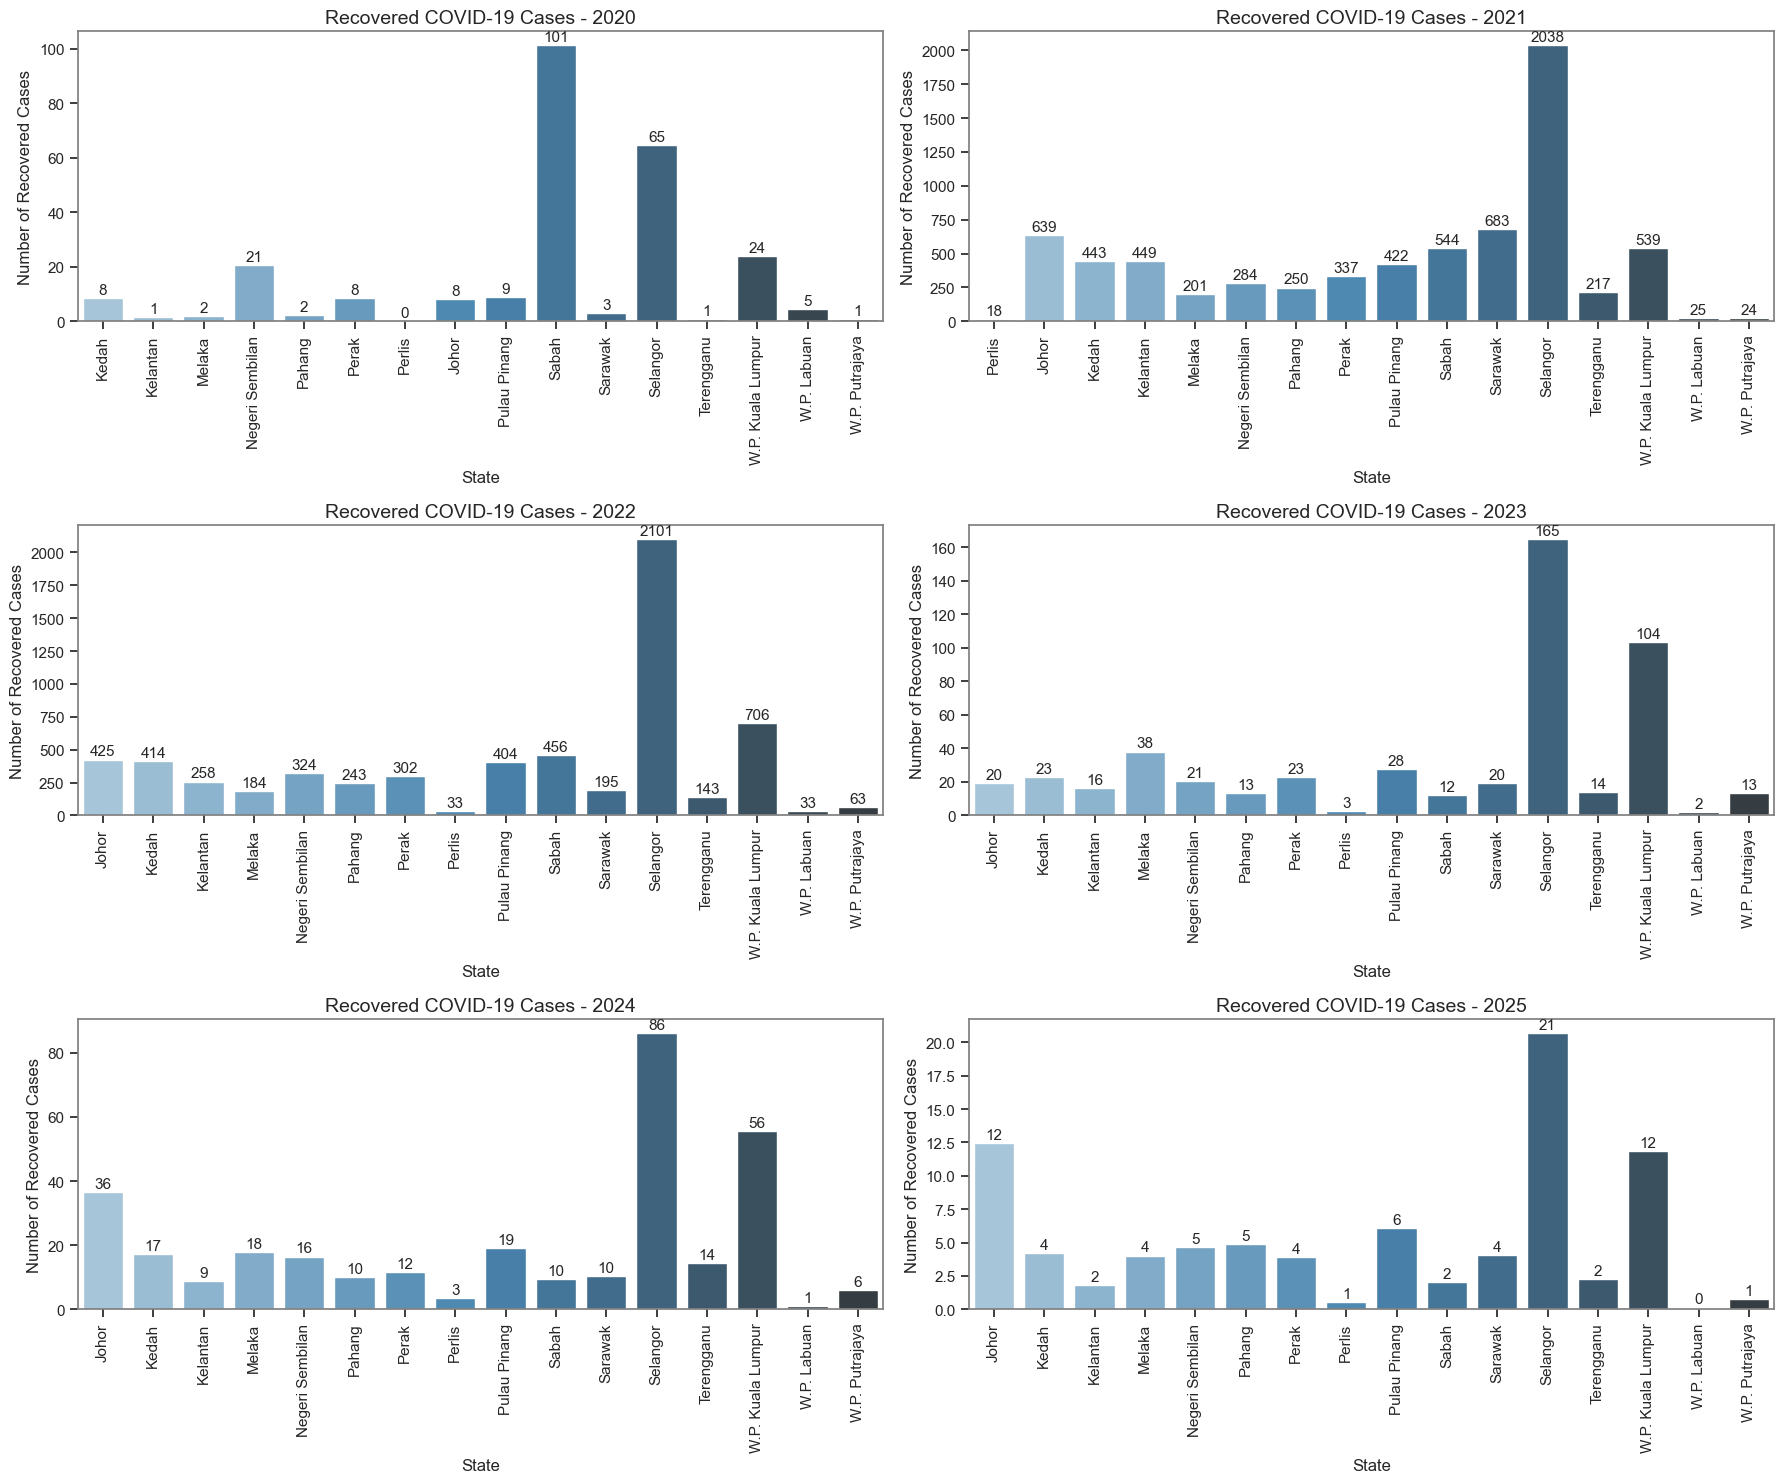

In [9]:
# Ensure consistent style
sns.set(style="ticks")

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

## Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = df_malaysia[df_malaysia['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_cases_recovered',
        ax=ax,
        palette='Blues_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'Recovered COVID-19 Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Recovered Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

# Adjust layout
plt.tight_layout()
plt.show()

The bar charts provided illustrate the trend of recovered COVID-19 cases in various states of Malaysia from the year 2020 to 2025. These visual data highlight both the severity of the pandemic in its early stages and the gradual improvement in recovery rates, likely influenced by public health measures, increased medical capacity, and the widespread rollout of vaccinations.

In the year 2021, the state of Selangor recorded the highest number of recovered cases, exceeding 2,000 on average, which indicates it was likely among the hardest-hit regions during the peak of the pandemic. This can be attributed to its status as the most populous and urbanized state, resulting in a higher transmission rate of the virus due to increased mobility and dense living conditions (Ministry of Helath Malaysia, 2021; Jayaraj et al., 2021). High case numbers naturally lead to a higher count of recoveries as well, assuming access to adequate medical treatment.

Moving into 2022, although recovery numbers remained significant in states like Selangor and Kuala Lumpur, a notable decline began to appear by 2023 and continued through 2024 and 2025. This sharp decrease in recovered cases is likely a consequence of the combined effects of the national vaccination campaign, which began in early 2021, and the development of natural immunity among the population (World Health Organization [WHO], 2022). The successful vaccination coverage reduced the severity and incidence of infections, hence resulting in fewer active cases and correspondingly fewer recoveries needed.

By 2025, the data shows a markedly reduced number of recoveries across all states, suggesting that the virus no longer posed a widespread threat to public health. This aligns with global trends where COVID-19 transitioned from a pandemic to an endemic stage, meaning the virus remained present but manageable with existing healthcare systems and public awareness (Centers for Disease Control and Prevention [CDC], 2023).

While the data reflect a positive trajectory, caution remains essential. The possibility of emerging variants still poses a potential risk. Continued surveillance, prompt response to outbreaks, and maintaining public health practices such as mask-wearing in high-risk areas and staying home when symptomatic are recommended to prevent resurgence (WHO, 2023).

**References:** 

Centers for Disease Control and Prevention. (2023). COVID-19: Endemic status and continued precautions. https://www.cdc.gov/covid/hcp/infection-control/index.html

Ministry of Health Malaysia. (2021). COVID-19 Updates and Statistics. https://www.moh.gov.my/

Jayaraj, V. J., Rampal, S., Ng, C.-W., & Chong, D. W. Q. (2021). The epidemiology of COVID-19 in Malaysia. The Lancet Regional Health – Western Pacific, 17, 100295. https://doi.org/10.1016/j.lanwpc.2021.100295

World Health Organization. (2022). COVID-19 vaccine tracker and landscape. https://www.who.int/news-room/questions-and-answers/item/coronavirus-disease-(covid-19)-vaccines

World Health Organization. (2023). Strategies for managing COVID-19 in the endemic phase. https://www.who.int/emergencies/diseases/novel-coronavirus-2019

#### **4.2.4 Active COVID-19 Cases By State (2020 - 2025)**

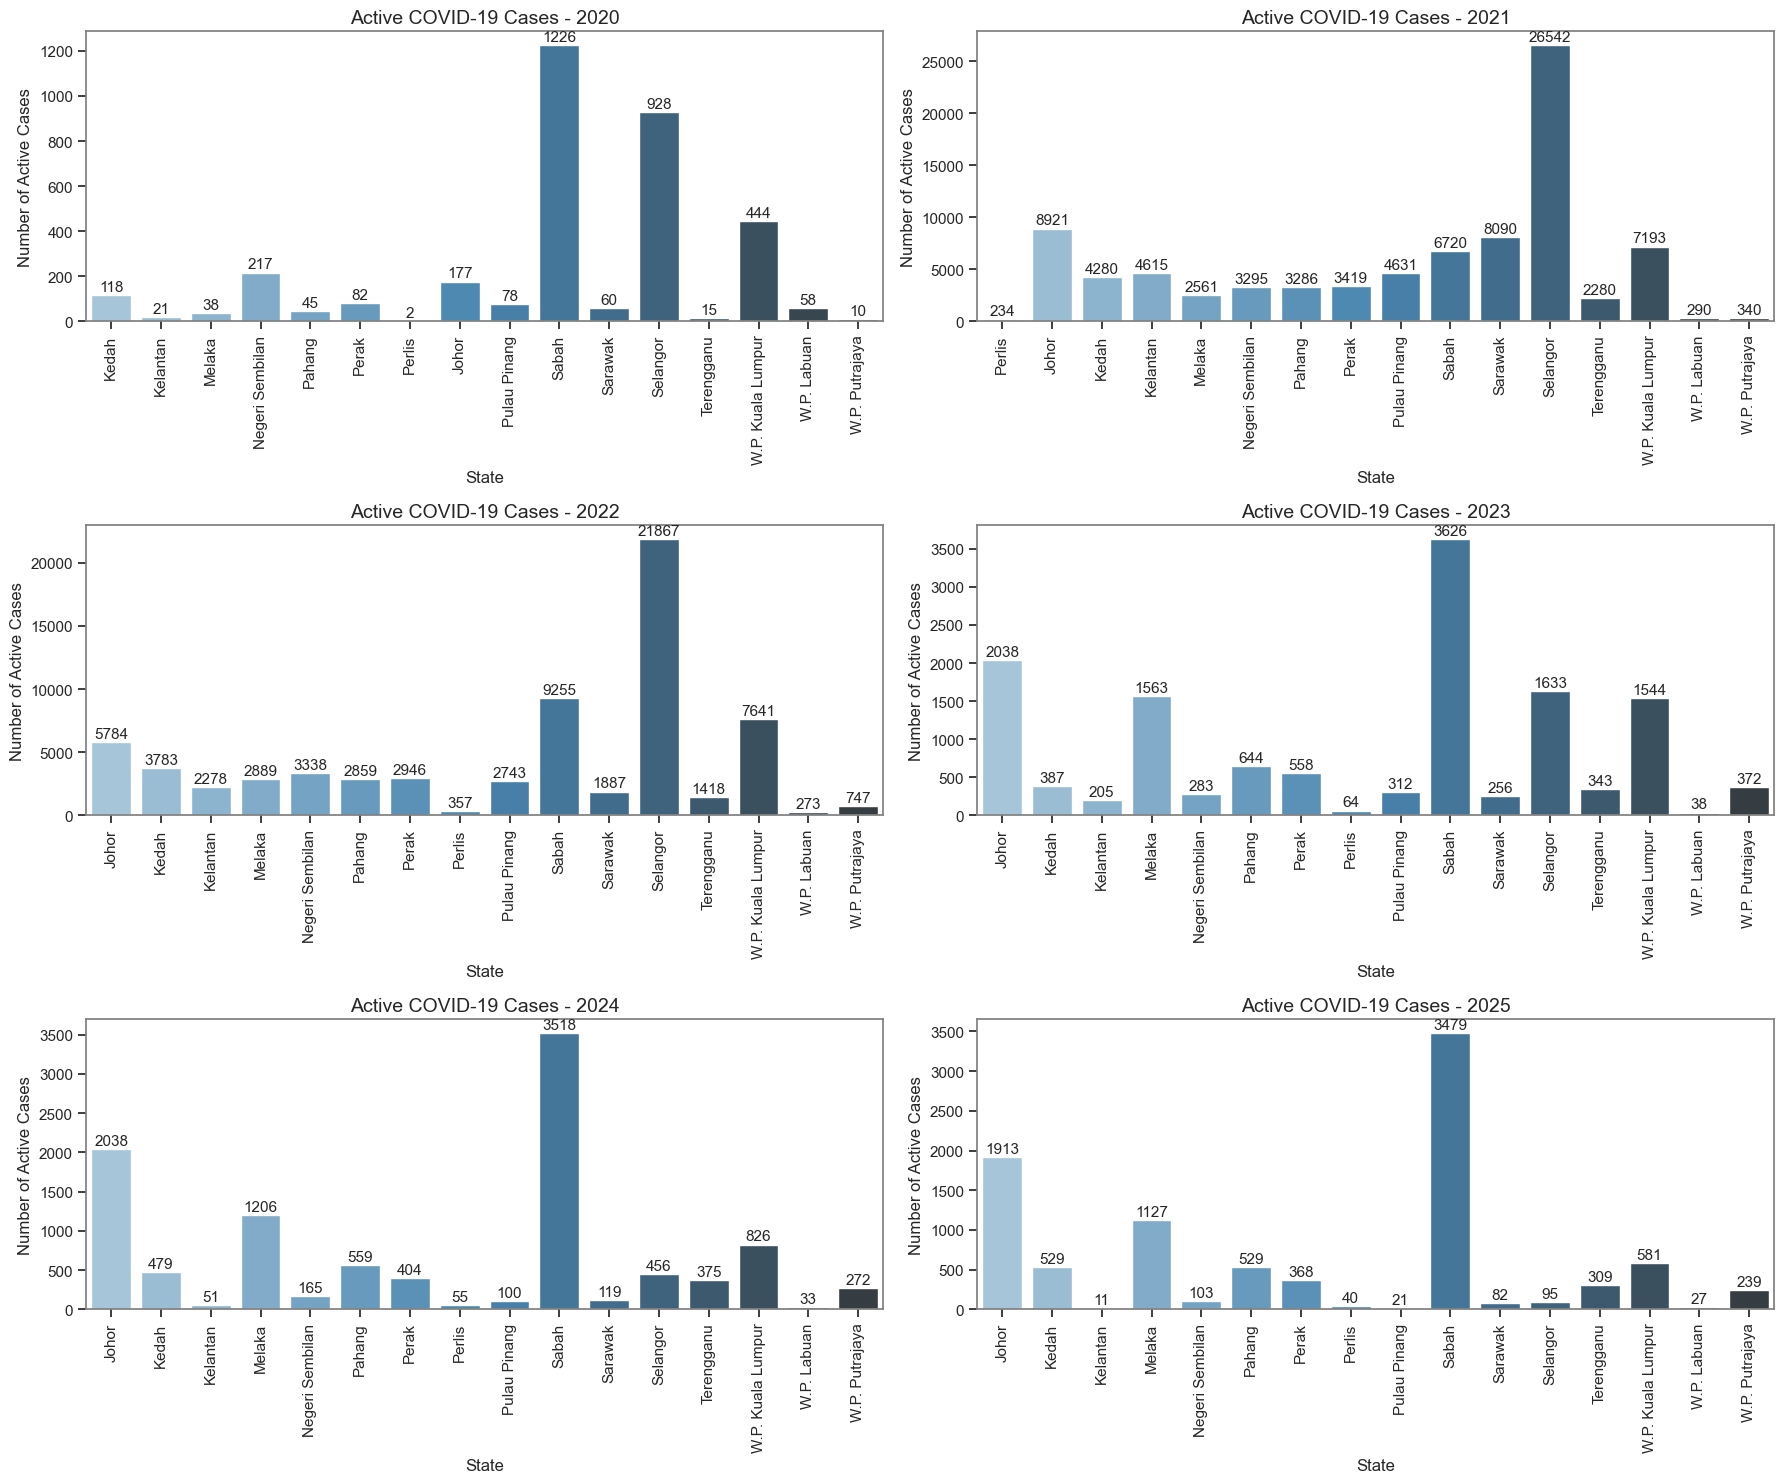

In [10]:
# Ensure consistent style
sns.set(style="ticks")

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

## Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = df_malaysia[df_malaysia['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_active_cases',
        ax=ax,
        palette='Blues_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'Active COVID-19 Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Active Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')


# Adjust layout
plt.tight_layout()
plt.show()

The trend in active COVID-19 cases from 2020 to 2025 across Malaysian states reflects the shifting dynamics of the pandemic response and regional vulnerabilities. The visual data reveals significant yearly variation, with certain states repeatedly emerging as high-burden areas. Among these, Sabah, Selangor, and W.P. Kuala Lumpur consistently reported elevated numbers of active COVID-19 cases, albeit at different points in time.

In 2020, Sabah recorded the highest number of active COVID-19 cases (1,266 cases), likely due to a combination of logistical challenges, limited healthcare infrastructure, and late containment measures in the state. This is consistent with reports of delayed resource allocation and limited ICU capacity in East Malaysia at the onset of the pandemic (Ministry of Health Malaysia, 2021). Selangor and W.P. Kuala Lumpur, as densely populated urban hubs, also showed high case numbers early on due to increased human mobility and population density which is the key risk factors for rapid virus transmission (Ang et al., 2021).

By 2021, Selangor saw a dramatic surge, recording 26,542 active cases, the highest across all states that year. This can be attributed to its status as the most populous state and Malaysia’s primary economic engine, which led to sustained industrial operations even during movement control orders. Urban overcrowding, along with high testing rates, likely contributed to this spike (Zulkifli et al., 2022). Sabah also remained among the top contributors, further highlighting its susceptibility to prolonged outbreaks.

In 2022, Selangor again topped the list with 21,867 cases, while Sabah (9,255) and W.P. Kuala Lumpur (7,641) followed. The persistently high figures in these states reflect both endemic transmission and challenges in vaccination coverage or public adherence to SOPs (standard operating procedures) during the pandemic’s mid-phase.

Interestingly, the year 2023 marked a shift, with Sabah recording the highest number of active cases (3,626), overtaking Selangor. This indicates a regional flare-up, possibly influenced by post-pandemic travel normalization, under-resourced rural healthcare, and delays in booster vaccine rollouts. States like Johor (2,038 cases) and Melaka (1,563 cases) also began to show higher figures, suggesting wider geographical spread beyond early urban centers.

The pattern continued into 2024 and 2025, with Sabah maintaining the highest number of cases both years (3,518 in 2024 and 3,479 in 2025). The recurrence of Sabah as a COVID-19 hotspot underscores structural challenges, such as geographic isolation, limited healthcare access, and possible disparities in vaccination or preventive health campaigns (WHO, 2023). Johor and Melaka also consistently reported higher figures in the latter years, likely due to interstate movement and being economic transition zones attracting workforce mobility.

This longitudinal data reinforces the need for a localized pandemic response strategy that addresses structural healthcare weaknesses and demographic vulnerabilities. Proactive measures such as mobile vaccination units, improved data surveillance, and public education in high-risk states like Sabah and Selangor are crucial for long-term preparedness and control.

**References:**

Ang, Z. Y., Cheah, K. Y., Shakirah, M. S., Fun, W. H., Anis-Syakira, J., Kong, Y.-L., & Sararaks, S. (2021). Malaysia’s Health Systems Response to COVID-19. International Journal of Environmental Research and Public Health, 18(21), 11109. https://doi.org/10.3390/ijerph182111109

Zulkifli, Z. A., & Mohd Zain, Z. (2022). The vulnerability to a COVID-19 outbreak in Malaysia: Panel analysis during the endemic phase.  Journal  of  Governance  and  Development, 18(1),1-9. https://doi.org/10.32890/jgd2022.18.1.

Ministry of Health Malaysia. (2021). COVID-19 Updates. https://covidnow.moh.gov.my/

World Health Organization (WHO). (2023). Malaysia COVID-19 Situation Reports. https://www.who.int/malaysia/emergencies/covid-19-in-malaysia/situation-reports

### **4.3 Demographic Visualization COVID-19 Cases in 2025**

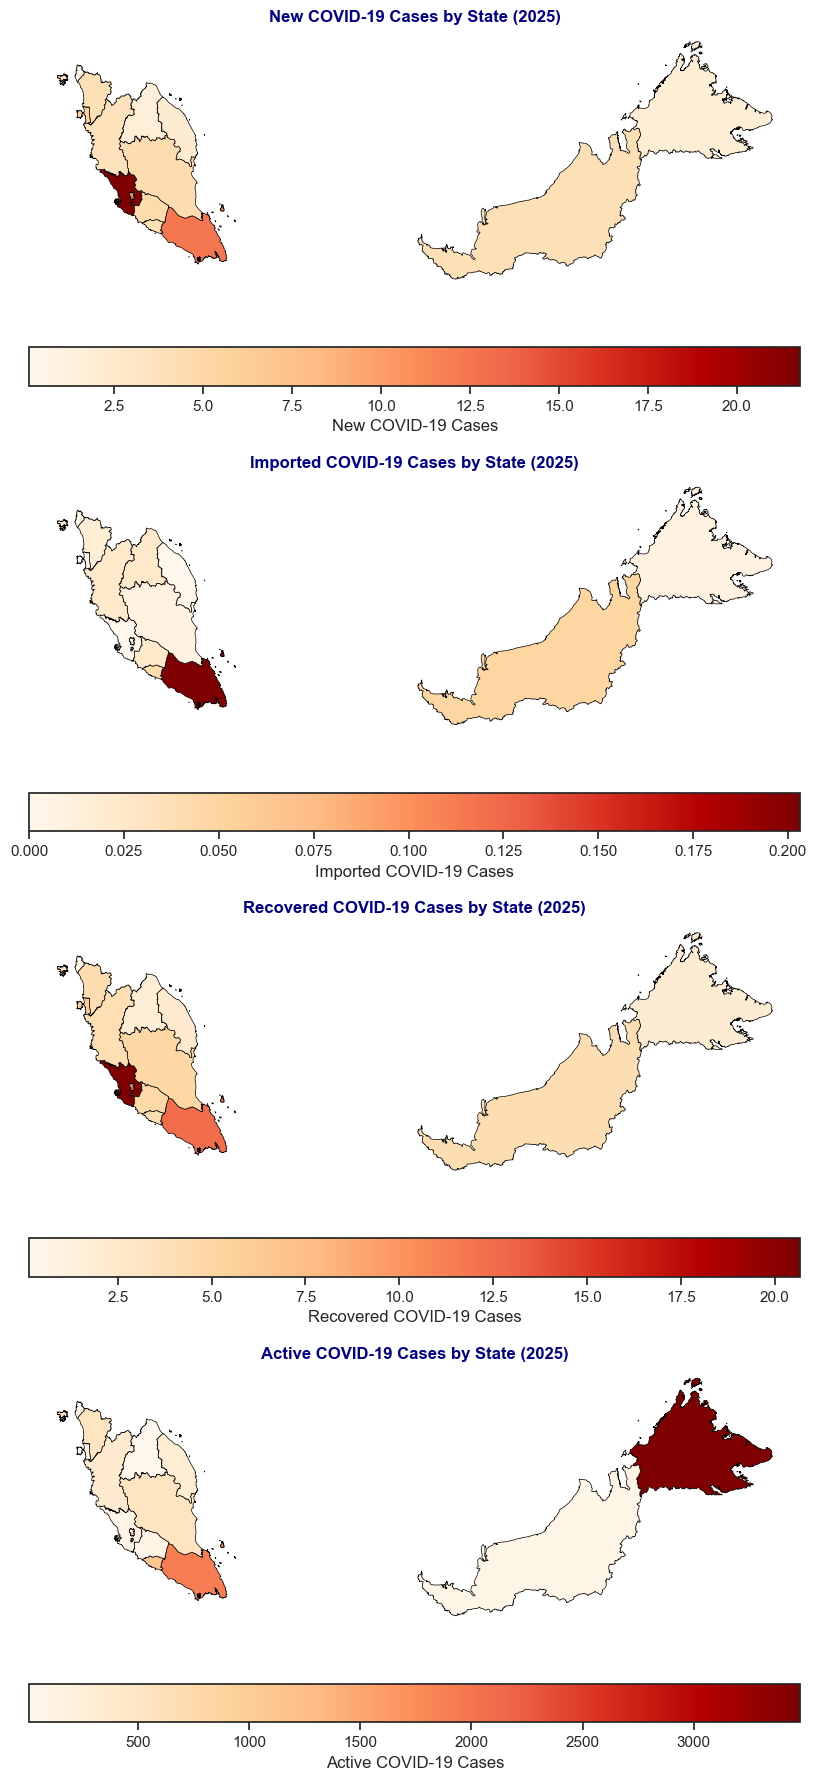

In [11]:
# Load shapefile from GitHub
shapefile_path = "https://raw.githubusercontent.com/manarifz/Assignment-1-Data-Management/main/ShapeFile%20Malaysia/malaysia%20state%20v2.shp"
gdf = gpd.read_file(shapefile_path)

# Filter COVID data for the year 2025 and exclude 'Malaysia' row
covid_2025 = covid_cases[(covid_cases['year'] == 2025) & (covid_cases['state'] != 'Malaysia')]

# Select only required columns
df_covid = covid_2025[['state', 'avg_new_cases', 'avg_import_cases', 'avg_cases_recovered', 'avg_active_cases']]

# Merge geospatial data with filtered COVID data
merged_gdf = gdf.merge(df_covid, on='state')

# Set up the plot with subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 18))  # 3 rows, 1 column
axes = axes.flatten()

# Columns to plot and their titles
columns_to_plot = ['avg_new_cases', 'avg_import_cases', 'avg_cases_recovered', 'avg_active_cases']
titles = ['New COVID-19 Cases', 'Imported COVID-19 Cases', 'Recovered COVID-19 Cases', 'Active COVID-19 Cases']

# Plot each variable
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    merged_gdf.plot(column=col,
                    cmap='OrRd',
                    ax=ax,
                    legend=True,
                    legend_kwds={'label': titles[i], 'orientation': 'horizontal', 'shrink': 0.8},
                    edgecolor='black', linewidth=0.5)
    ax.set_title(f'{titles[i]} by State (2025)', fontsize=12, fontweight='bold', color='darkblue')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


The 2025 geographic heat maps provide critical insights into the distribution of COVID-19 cases across Malaysia, highlighting key regions that require focused public health interventions. The maps reveal that Selangor, W.P. Kuala Lumpur, and Johor report the highest densities of new, imported, and recovered COVID-19 cases. These areas are recognized as major urban and economic hubs, characterized by high population density and significant human mobility. This environment facilitates rapid viral transmission, making disease containment more difficult despite ongoing health efforts (Ministry of Health Malaysia, 2021). Johor, in particular, shows a significant number of imported cases, which is likely attributed to its proximity to Singapore and the high volume of cross-border movement. This finding emphasizes the importance of strict border control measures and health screenings at entry points (Worsnop et al., 2023).

In terms of recovered cases, Selangor, Kuala Lumpur, and Johor also show high numbers, indicating that while the healthcare systems in these regions are managing to treat and discharge a large number of patients, the continuous influx of new cases places ongoing pressure on health infrastructure. Therefore, localized lockdowns, mass testing and contact tracing, and booster vaccination campaigns are essential to mitigate the spread in these high-risk areas (Centers for Disease Control and Prevention, 2023).

The most notable observation from the active COVID-19 cases map is the sharp concentration of unresolved cases in Sabah. Unlike Selangor or Johor, Sabah does not show the highest new or imported case rates but still records the largest number of active cases. This discrepancy suggests the presence of persistent community transmission that may be driven by challenges such as limited access to healthcare services, lower vaccination coverage, or delayed detection and treatment. These factors indicate a need for enhanced public health outreach, mobile health units, and improved surveillance strategies in Sabah to reduce the burden of ongoing infections (World Health Organization, 2023).

Overall, the updated visualization of COVID-19 metrics calls for a dual strategic response. Urban regions like Selangor, Kuala Lumpur, and Johor require sustained containment measures including testing, contact tracing, and public awareness campaigns. At the same time, Sabah demands targeted community-level interventions that address the unique healthcare challenges of rural and remote populations. The spatial visualization of cases allows for better resource allocation and policy decision-making, ensuring a more responsive and equitable public health approach across Malaysia.

**References:**

Centers for Disease Control and Prevention. (2022). CDC Strategy for Global Response to COVID-19 (2020-2023). https://archive.cdc.gov/www_cdc_gov/coronavirus/2019-ncov/global-covid-19/global-response-strategy.html

Ministry of Health Malaysia. (2021). COVID-19 Situation Report: Urban area risks and healthcare response. https://covidnow.moh.gov.my/

Worsnop, C. Z., Grépin, K. A., Lee, K., & Marion, S. (2023). The unintended consequences of information provision: the world health organization and border restrictions during COVID-19. International Studies Perspectives, 24(1), 39-66.

World Health Organization. (2024). COVID-10 Surveillance. https://www.who.int/docs/default-source/coronaviruse/policy-briefs/policy-brief_covid-19_surveillance.pdf

#### **4.4 Sexually Transmitted Diseases (STDs) Trends in Malaysia (2017 - 2022)**

**4.4.1 Trends of AIDS, Gonorrhea, HIV and Syphillis cases in Malaysia (2017 - 2022)**

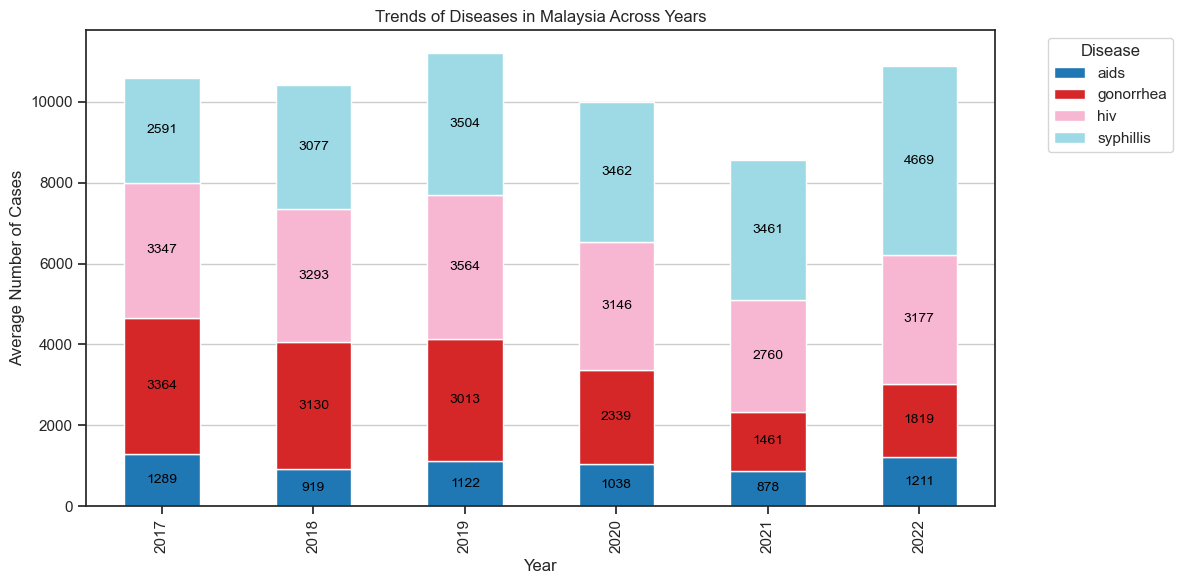

In [12]:
# Filter out rows where state is 'Malaysia' and disease is not 'chancroid'
filtered_df = df[(df['state'] == 'Malaysia') & (df['disease'] != 'chancroid')]

# Group by year and disease to get the sum or average of cases
df_grouped = filtered_df.groupby(['year', 'disease'])['avg_cases'].sum().unstack(fill_value=0)

# Plot
ax = df_grouped.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Trends of Diseases in Malaysia Across Years')
plt.xlabel('Year')
plt.ylabel('Average Number of Cases')
plt.legend(title='Disease', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')

# Add value labels on each bar segment
for bar_index, year in enumerate(df_grouped.index):
    cumulative_height = 0
    for disease in df_grouped.columns:
        value = df_grouped.loc[year, disease]
        if value > 0:
            ax.text(
                bar_index, # X coordinate
                cumulative_height + value / 2, # Y coordinate at middle of segment
                str(int(value)), # Text
                ha='center', va='center', fontsize=10, color='black'
            )
        cumulative_height += value

plt.show()


The visual data on the trends of sexually transmitted diseases (STDs) in Malaysia from 2017 to 2022 provides a compelling narrative of how public health dynamics can shift significantly in response to external factors, particularly the COVID-19 pandemic. The graph highlights that cases of syphilis and HIV showed a steady increase from 2017 to 2019, suggesting either an actual rise in transmission or improved detection and reporting mechanisms during that period. In contrast, gonorrhea and AIDS cases showed a declining trend, potentially due to effective public health campaigns, improved access to healthcare, or changes in sexual behavior.

A significant decline in reported STD cases is observed across all categories in the years 2020 and 2021. This drop aligns temporally with the onset of the COVID-19 pandemic and the implementation of strict public health measures by the Malaysian government, such as the Movement Control Order (MCO), which restricted interpersonal interactions, travel, and social gatherings (Pang et al., 2021). These restrictions likely led to reduced sexual activity, particularly casual or non-household interactions, thereby lowering the transmission opportunities for STDs. Similar patterns were noted globally, as social distancing and lockdown measures were associated with decreased reported cases of various STDs due to both reduced transmission and fewer people seeking testing (Centers for Disease Control and Prevention [CDC], 2021).

The data for 2022, however, shows a resurgence in STD cases—most notably a sharp increase in syphilis and HIV cases. This rebound could be attributed to several factors. Firstly, the relaxation of COVID-19 restrictions, including the reopening of borders and increased interstate travel, likely facilitated a return to pre-pandemic social behaviors, including intimate relationships. Secondly, with the establishment of widespread vaccination and a gradual return to normalcy, individuals may have resumed healthcare visits, leading to increased testing and reporting of STDs that went undetected during the pandemic (Contarino et al., 2024).

This trend underscores the importance of maintaining robust sexual health education, accessible STD screening, and public health surveillance even amidst other public health crises. It also highlights how shifts in policy and mobility can directly influence public health outcomes, especially for communicable diseases that depend heavily on human contact for transmission.

**References:**

Centers for Disease Control and Prevention. (2021). Impact of COVID-19 on STIs. https://www.cdc.gov/sti-statistics/about/impact-of-covid-19.html

Pang, N. T. P., Kamu, A., Mohd Kassim, M. A., & Ho, C. M. (2021). Monitoring the impact of Movement Control Order (MCO) in flattening the cumulative daily cases curve of COVID-19 in Malaysia: A generalized logistic growth modeling approach. Infectious Disease Modelling, 6, 898–908. https://doi.org/10.1016/j.idm.2021.07.004

Contarino, F., Bella, F., DI Pietro, E., Randazzo, C., & Contrino, M. L. (2024). Impact of the COVID-19 pandemic on infectious diseases reporting. Journal of preventive medicine and hygiene, 65(2), E145–E153. https://doi.org/10.15167/2421-4248/jpmh2024.65.2.3197

**4.4.2 Trends of Chancroid cases in Malaysia (2017 - 2022)**

In [13]:
df[df['disease'] == 'chancroid'].head(6)

,year,state,disease,avg_cases,avg_incidence
1,2017,Johor,chancroid,1.0,0.03
6,2017,Kedah,chancroid,0.0,0.00
11,2017,Kelantan,chancroid,0.0,0.00
16,2017,Malaysia,chancroid,3.0,0.01
21,2017,Melaka,chancroid,0.0,0.00
26,2017,Negeri Sembilan,chancroid,0.0,0.00


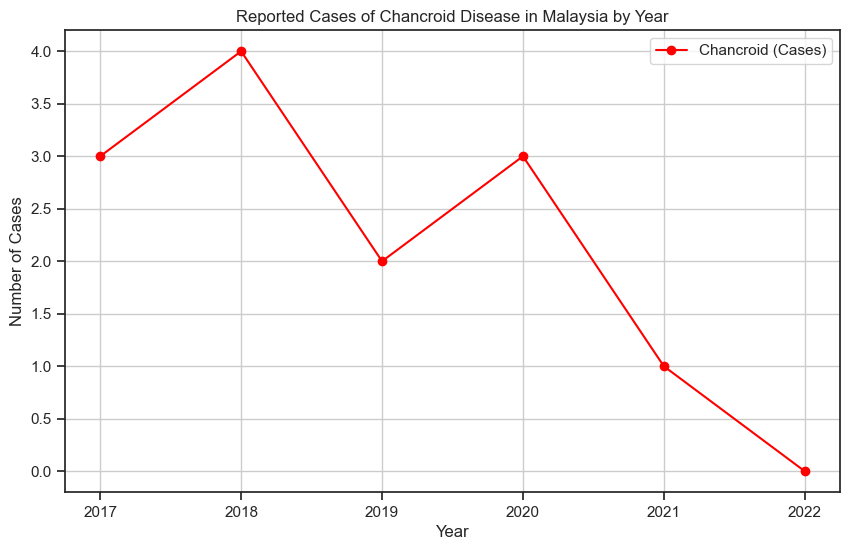

In [14]:
# Filter only for Malaysia
df_malaysia_2 = df[df['state'] == 'Malaysia'].sort_values(by='year')

# Filter data for each disease
chancroid = df_malaysia_2[df_malaysia_2['disease'] == 'chancroid']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chancroid['year'], chancroid['avg_cases'], marker='o', label='Chancroid (Cases)', color='red')

plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.title('Reported Cases of Chancroid Disease in Malaysia by Year')
plt.legend()
plt.grid(True)
plt.show()


The reported cases of chancroid in Malaysia between 2017 and 2022 reveal a consistently declining trend, with a noticeable drop to zero cases by 2022. Despite minor fluctuations between 2017 and 2020, the overall trajectory indicates effective control of the disease. Chancroid, a bacterial sexually transmitted infection caused by Haemophilus ducreyi, has become increasingly rare in many parts of the world due to several public health advancements. One of the primary reasons for the decline in chancroid cases is the widespread availability and use of effective antibiotic treatments, which can quickly cure the infection and reduce its transmission (World Health Organization [WHO], 2016).

Additionally, chancroid is more sensitive to improvements in public health infrastructure, including better diagnostics, sexual health education, and access to treatment, compared to viral STDs like HIV and syphilis which require long-term management or do not have a definitive cure. The consistent public health efforts in Malaysia, including targeted screening and contact tracing, may have further contributed to the successful containment of chancroid. The integration of syndromic management protocols in clinical settings—where patients presenting with genital ulcers are treated presumptively for chancroid, syphilis, and herpes—also plays a vital role in controlling chancroid without requiring laboratory confirmation in every case (Centers for Disease Control and Prevention [CDC], 2021).

Moreover, the decline in chancroid cases aligns with global epidemiological trends. According to international data, chancroid has become extremely rare in developed and developing nations alike due to a combination of improved healthcare services and changing sexual health behaviors (Currie, 2023). Therefore, the reduction in chancroid incidence in Malaysia may not solely reflect a cure, but rather a successful public health model combining prevention, education, and treatment.

**References:**

Centers for Disease Control and Prevention. (2021). Sexually Transmitted Disease Surveillance 2021. https://www.cdc.gov/sti-statistics/media/pdfs/2024/07/2021-STD-Surveillance-Report-PDF_ARCHIVED-2-16-24.pdf

Currie, B. P. (2023). Chancroid. In Sexually Transmitted Diseases (pp. 59-74). CRC Press.

World Health Organization. (2016). Sexually transmitted infections (STIs): Fact sheet. https://www.who.int/news-room/fact-sheets/detail/sexually-transmitted-infections-(stis)

#### **4.5 Number of STDs Cases By State (2022)**

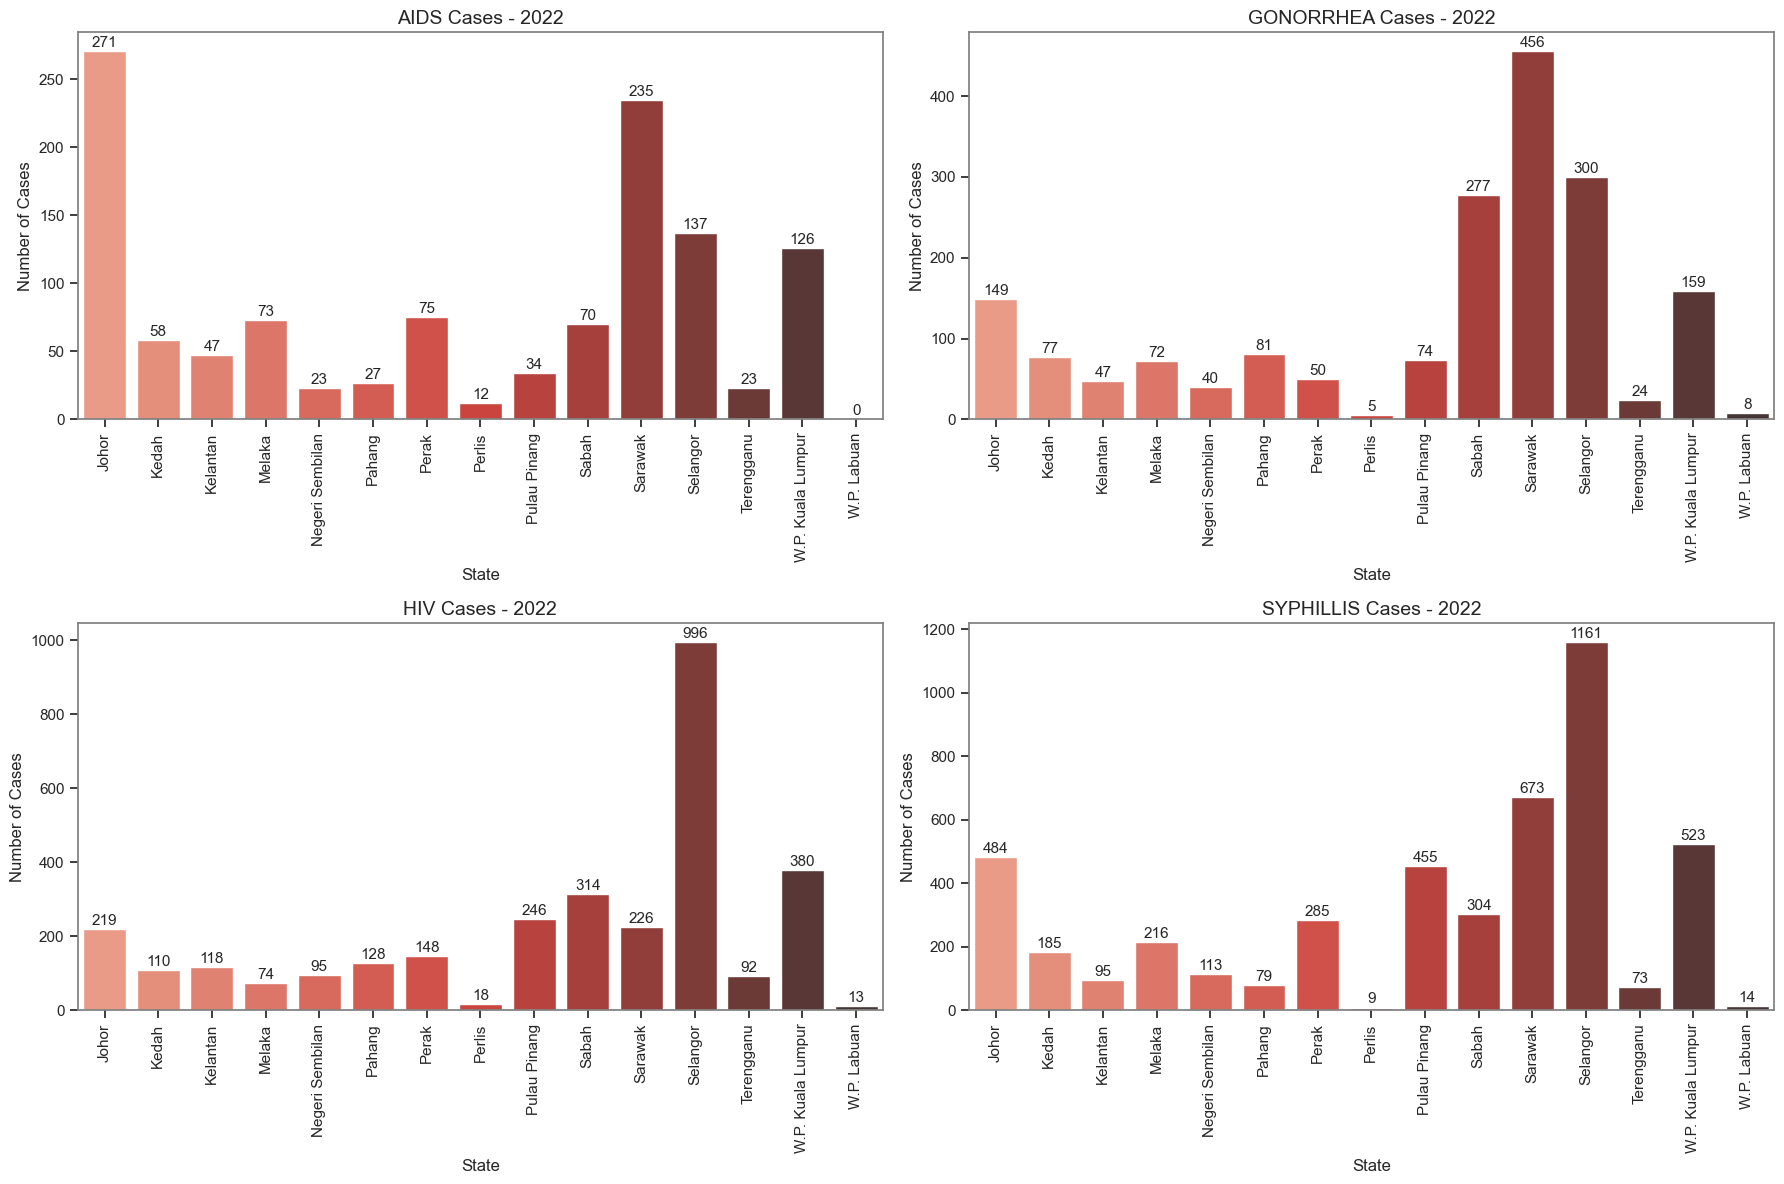

In [15]:
# Filter the data for year 2022 and selected diseases
diseases_2022 = df[(df['state'] != 'Malaysia') & 
                   (df['year'] == 2022) & 
                   (df['disease'].isin(['aids', 'gonorrhea', 'hiv', 'syphillis']))]

# Ensure consistent style
sns.set(style="ticks")

# List of diseases to visualize
disease_list = ['aids', 'gonorrhea', 'hiv', 'syphillis']

# Create subplots (2 rows x 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

# Loop through each disease and plot on a separate subplot
for i, disease in enumerate(disease_list):
    ax = axes[i]
    data_disease = diseases_2022[diseases_2022['disease'] == disease]
    
    # Plot the barplot
    barplot = sns.barplot(
        data=data_disease,
        x='state',
        y='avg_cases',
        ax=ax,
        palette='Reds_d'
    )

    # Add value labels
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'{disease.upper()} Cases - 2022', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set plot border color
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

# Adjust layout
plt.tight_layout()
plt.show()


Based on the 2022 data, it is evident that the distribution of sexually transmitted diseases (STDs) such as AIDS, gonorrhea, HIV, and syphilis across Malaysian states is uneven, with certain states consistently reporting higher incidences. Among these, Selangor, Sarawak, W.P. Kuala Lumpur, and Johor emerge as the top contributors to the national burden of STDs. These patterns may be influenced by several socioeconomic and demographic factors including population density, urbanization, access to healthcare, and patterns of internal migration.

Selangor recorded the highest number of HIV (996 cases) and syphilis (1161 cases) cases, likely due to its status as the most populous and urbanized state in Malaysia. Urban centers tend to have higher transmission rates of STDs due to increased anonymity, higher population mobility, and more diverse sexual networks (World Health Organization [WHO], 2023; New Strait Times, 2025). Selangor also offers more comprehensive healthcare facilities, leading to increased detection and reporting. Similarly, W.P. Kuala Lumpur, being a major metropolitan hub, reported high numbers across all STDs, including 380 HIV and 523 syphilis cases. These figures suggest that urbanization may correlate not only with increased transmission but also with better surveillance and reporting mechanisms.

Sarawak, which recorded the highest number of gonorrhea cases (456) and second highest AIDS cases (235), reflects a different scenario. While not as densely populated as Selangor or Kuala Lumpur, Sarawak’s relatively high STD figures may stem from challenges in healthcare access in remote and rural communities, leading to late diagnoses and ongoing transmission (Ministry of Health Malaysia, 2022). Additionally, cultural barriers and limited sexual health education in rural and indigenous communities may contribute to the persistence of STDs in this state.

Johor’s high AIDS (271) and syphilis (484) cases are also notable. Being a border state with significant cross-border movement and industrial employment, Johor is susceptible to increased sexual health risks among mobile populations, including foreign workers. Studies have shown that migrant populations often face limited access to preventive and treatment services, thereby increasing vulnerability to infections (UNAIDS, 2020).

In summary, the geographical distribution of STDs in Malaysia in 2022 underscores the impact of urbanization, healthcare accessibility, social mobility, and public health outreach on disease prevalence. These findings call for tailored regional strategies that consider local dynamics, enhance sexual health education, and improve access to testing and treatment to reduce the burden of STDs.

**References:**

Ministry of Health Malaysia. (2023).The Global AIDS Monitoring Report 2023. https://www.moh.gov.my/moh/resources/Penerbitan/Laporan/Umum/Laporan_Global_AIDS_Monitoring_2023.pdf

New Strait Times (2025). Malaysian AIDS Council: Increasing rate of HIV cases among students. https://www.nst.com.my/news/nation/2025/04/1207807/malaysian-aids-council-increasing-rate-hiv-cases-among-students

UNAIDS. (2020). UNAIDS data 2020. https://www.unaids.org/sites/default/files/media_asset/2020_aids-data-book_en.pdf

World Health Organization. (2022). Global progress report on HIV, viral hepatitis and sexually transmitted infections, 2021. https://www.who.int/publications/i/item/9789240027077




### **4.6 Demographic Visualization of STDs Cases Across State In Malaysia (2022)**

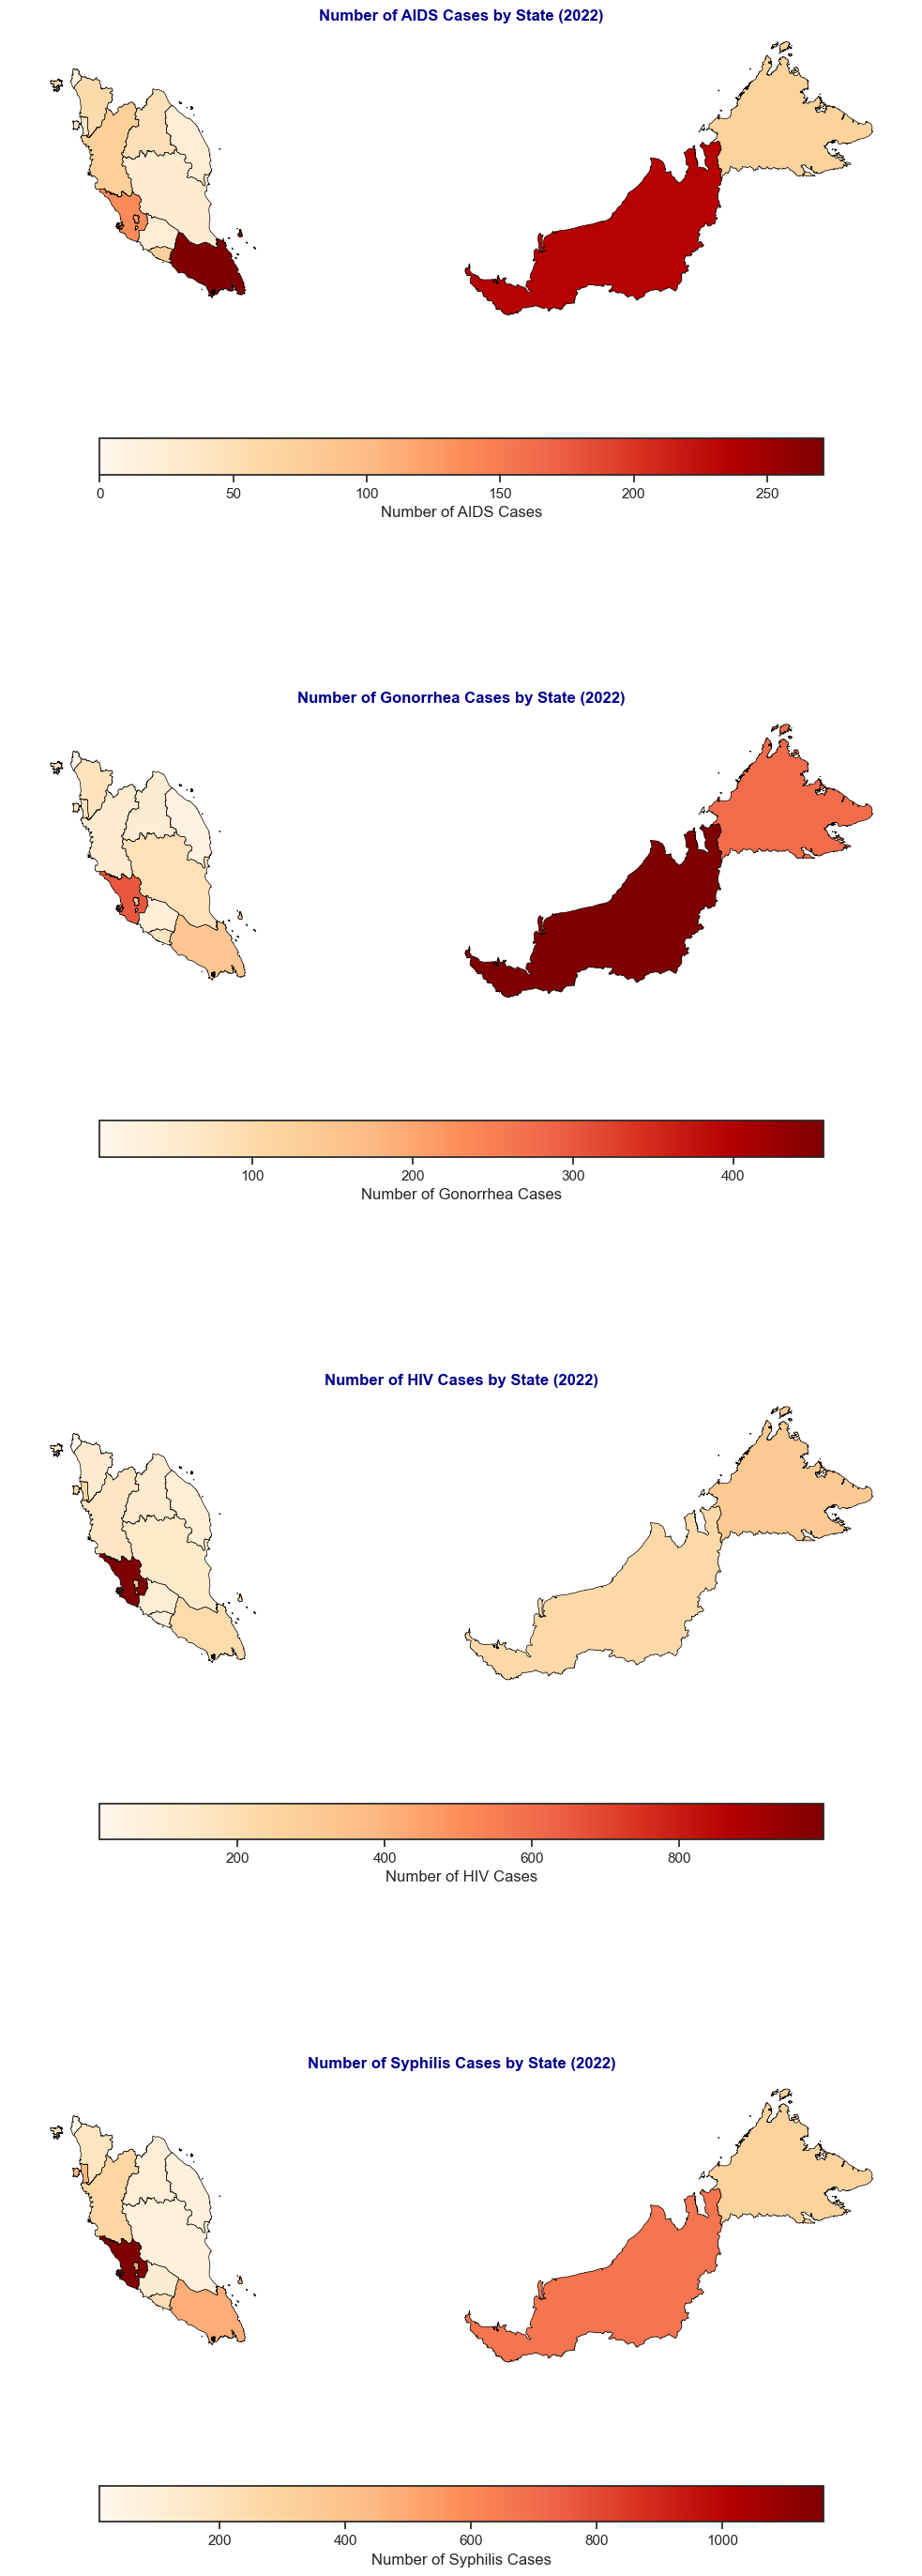

In [16]:
# Load shapefile from GitHub
shapefile_path2 = "https://raw.githubusercontent.com/manarifz/Assignment-1-Data-Management/main/ShapeFile%20Malaysia/malaysia%20state%20v2.shp"
gdf2 = gpd.read_file(shapefile_path2)

# List of diseases to map
diseases = ['aids', 'gonorrhea', 'hiv', 'syphillis']
titles = ['AIDS Cases', 'Gonorrhea Cases', 'HIV Cases', 'Syphilis Cases']

# Prepare subplots (5 rows x 1 column)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 30))
axes = axes.flatten()

# Loop through each disease
for i, disease in enumerate(diseases):
    # Filter data
    disease_data = df[
        (df['year'] == 2022) &
        (df['state'] != 'Malaysia') &
        (df['disease'] == disease)
    ][['state', 'avg_cases']]

    # Merge with geospatial data
    merged_gdf = gdf2.merge(disease_data, on='state', how='left')

    # Plot
    ax = axes[i]
    merged_gdf.plot(column='avg_cases',
                    cmap='OrRd',
                    ax=ax,
                    legend=True,
                    legend_kwds={'label': f'Number of {titles[i]}', 'orientation': 'horizontal', 'shrink': 0.8},
                    edgecolor='black', linewidth=0.5)
    ax.set_title(f'Number of {titles[i]} by State (2022)', fontsize=12, fontweight='bold', color='darkblue')
    ax.axis('off')

# Layout adjustment
plt.tight_layout()
plt.show()

Demographic visualizations play a crucial role in identifying and responding to public health threats, particularly in the context of sexually transmitted diseases (STDs). The 2022 geographic heatmaps of Malaysia highlight specific states as high-burden or “hotspot” areas for AIDS, gonorrhea, HIV, and syphilis. These visual insights enable targeted interventions, where the Ministry of Health (MOH) can allocate resources more efficiently and deploy tailored public health campaigns to curb further transmission.

For AIDS cases, the maps and data identify Sarawak, Johor, Selangor, and W.P. Kuala Lumpur as critical hotspots. Sarawak and Johor’s high figures may be attributed to healthcare access challenges and population mobility, particularly among migrant and rural communities (Ministry of Health Malaysia, 2023). In contrast, the high numbers in urban centers like Selangor and Kuala Lumpur may stem from increased testing availability and higher risk behaviors commonly associated with urbanized environments (UNAIDS, 2020).

In the case of gonorrhea, Sabah, Sarawak, Selangor, and W.P. Kuala Lumpur emerge as key hotspots. This pattern aligns with areas that have either high internal migration or large youth populations, both of which are associated with increased STD transmission risks (World Health Organization [WHO], 2022). Sabah and Sarawak may also reflect under-addressed sexual health education and limited screening facilities in remote regions, contributing to late diagnoses and continued disease transmission.

The visual representation of HIV cases clearly indicates Selangor as the most prominent hotspot, with nearly 1,000 cases. This can be justified by Selangor’s status as the most densely populated and economically active state in Malaysia. Urbanization tends to correlate with higher HIV incidence due to a combination of social and economic factors including population mobility, greater anonymity in urban settings, and increased exposure to high-risk behaviors (WHO, 2022). Therefore, ongoing monitoring and prevention initiatives in Selangor are critical to controlling the spread of HIV at the national level.

For syphilis, the map highlights Selangor, W.P. Kuala Lumpur, Johor, Sarawak, Pulau Pinang, and Sabah as major hotspots. This broader spread suggests a resurgence of syphilis in both urban and semi-urban areas, which may reflect gaps in sexual health education, inconsistent use of protection, or insufficient access to regular STD screening services (CDC, 2021). Particularly in urban centers like Kuala Lumpur and Penang, lifestyle factors and more open sexual networks could be contributing to the rise in cases.

These demographic insights emphasize the importance of geographically focused interventions. Policies should prioritize hotspot regions with enhanced screening, public awareness campaigns, access to free or subsidized treatment, and comprehensive sexual health education. Integrating such visual data into health planning will allow the MOH to address STD outbreaks more effectively and prevent cross-state transmission.

**References:**

Ministry of Health Malaysia. (2023).The Global AIDS Monitoring Report 2023. https://www.moh.gov.my/moh/resources/Penerbitan/Laporan/Umum/Laporan_Global_AIDS_Monitoring_2023.pdf

UNAIDS. (2020). UNAIDS data 2020. https://www.unaids.org/sites/default/files/media_asset/2020_aids-data-book_en.pdf

World Health Organization. (2022). Global progress report on HIV, viral hepatitis and sexually transmitted infections, 2021. https://www.who.int/publications/i/item/9789240027077

Centers for Disease Control and Prevention. (2021). Sexually Transmitted Disease Surveillance 2021. https://www.cdc.gov/sti-statistics/media/pdfs/2024/07/2021-STD-Surveillance-Report-PDF_ARCHIVED-2-16-24.pdf

## **6.0 FUTURE RECOMMENDATIONS**

To strengthen public health surveillance and response mechanisms in Malaysia, it is essential to enhance the granularity and timeliness of infectious disease data, particularly for COVID-19 and sexually transmitted diseases (STDs). Future research should integrate additional socioeconomic, environmental, and demographic variables to provide deeper insights into the social determinants of disease spread. Establishing real-time data pipelines through centralized platforms such as MyGDX can significantly improve the responsiveness of health interventions (Ministry of Digital Malaysia, 2024).

Moreover, collaboration with academic institutions and private health sectors is crucial to ensure data comprehensiveness and reduce underreporting. Advanced predictive modeling techniques, such as machine learning and geospatial analysis, should be employed to anticipate outbreaks and allocate resources efficiently (Zhao et al., 2024; Babanejaddehaki et al., 2025). Finally, public health education campaigns tailored to high-risk states like Selangor and Sabah should be prioritized to reduce STD transmission, coupled with mobile outreach and accessible testing services, especially among youth and underserved populations.

**References:**

Ministry of Digital Malaysia (2024). Pelan Strategik JDN 2024-2026. https://www.jdn.gov.my/wp-content/uploads/2025/01/Pelan-Strategik-JDN-2024-2026.pdf

Babanejaddehaki, G., An, A., & Papagelis, M. (2025). Disease outbreak detection and forecasting: A review of methods and data sources. ACM Transactions on Computing for Healthcare, 6(2), Article 13, 1–40. https://doi.org/10.1145/3708549

Zhao, A. P., Li, S., Cao, Z., Hu, P. J.-H., Wang, J., Xiang, Y., Xie, D., & Lu, X. (2024). AI for science: Predicting infectious diseases. Journal of Safety Science and Resilience, 5(2), 130–146. https://doi.org/10.1016/j.jnlssr.2024.02.002


## **7.0 CONCLUSION**

This project has demonstrated the importance of combining infectious disease data with spatial and temporal analysis to uncover key public health trends in Malaysia. The analysis of COVID-19 and STD cases across Malaysian states revealed significant geographic disparities and temporal patterns, highlighting the vulnerability of densely populated and economically active regions. Apache Hive proved effective for data preprocessing, while visualization tools like Matplotlib, Seaborn, and GeoPandas enabled clear identification of disease hotspots and potential correlations. These insights are vital for informing targeted interventions, optimizing health resource allocation, and shaping future public health strategies. As Malaysia continues to face evolving health challenges, data-driven decision-making must remain at the core of national policy to ensure equitable and effective health outcomes for all citizens.

## **8.0 ADDITIONAL SUPPLEMENTARY DATA**

#### **8.1 AIDS Cases By State (2017 - 2022)**

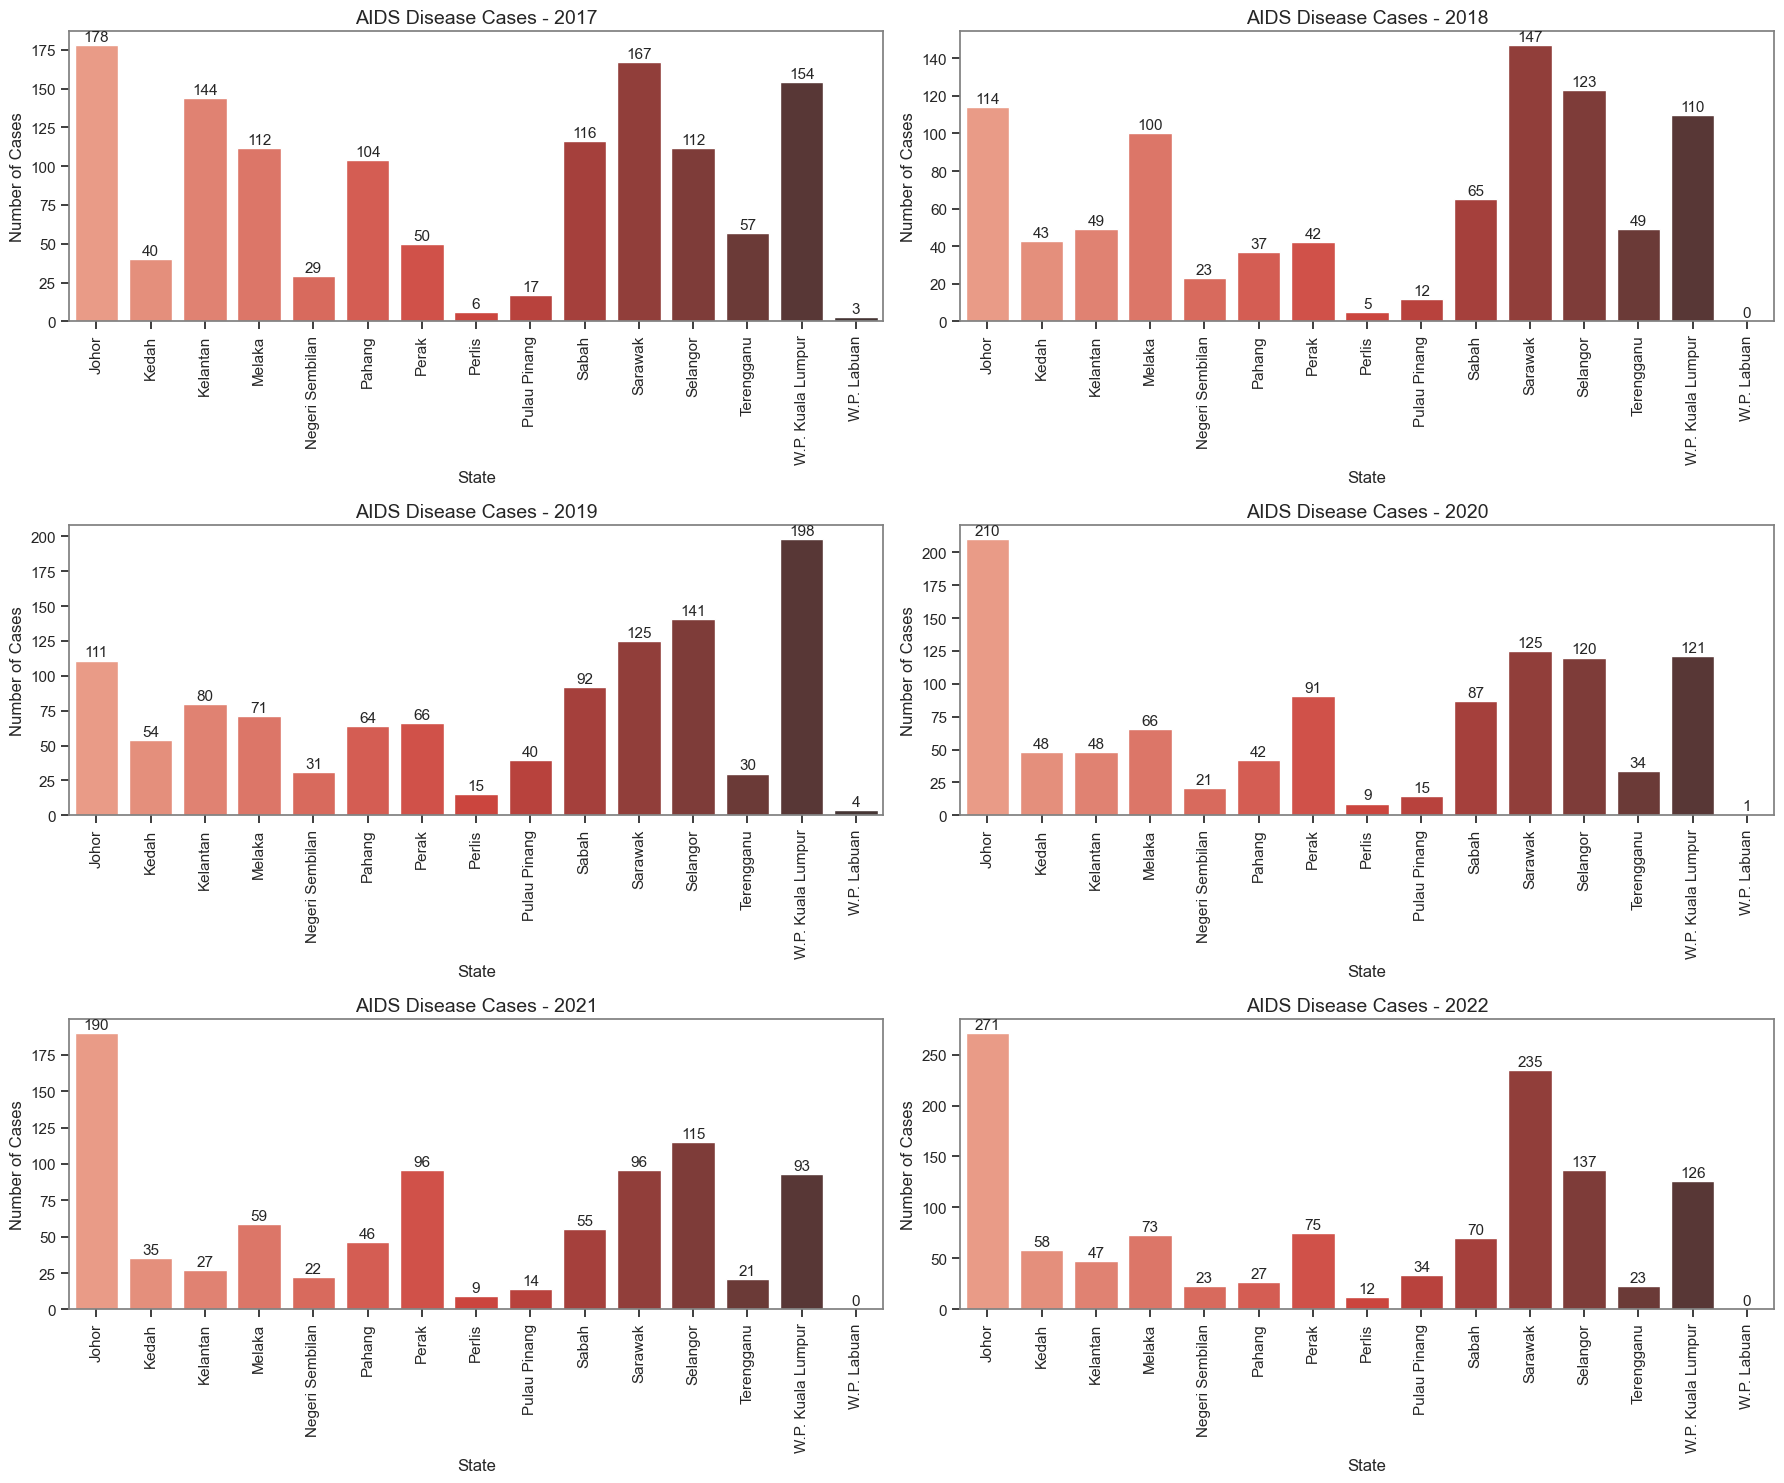

In [17]:
aids = df[(df['state'] != 'Malaysia') & (df['disease'] == 'aids')]

# Ensure consistent style
sns.set(style="ticks")

# Define the years to visualize
years = [2017, 2018, 2019, 2020, 2021, 2022]

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

# Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = aids[aids['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_cases',
        ax=ax,
        palette='Reds_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'AIDS Disease Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

# Adjust layout
plt.tight_layout()
plt.show()

#### **8.2 Gonorrhea Cases By State (2017 - 2022)**

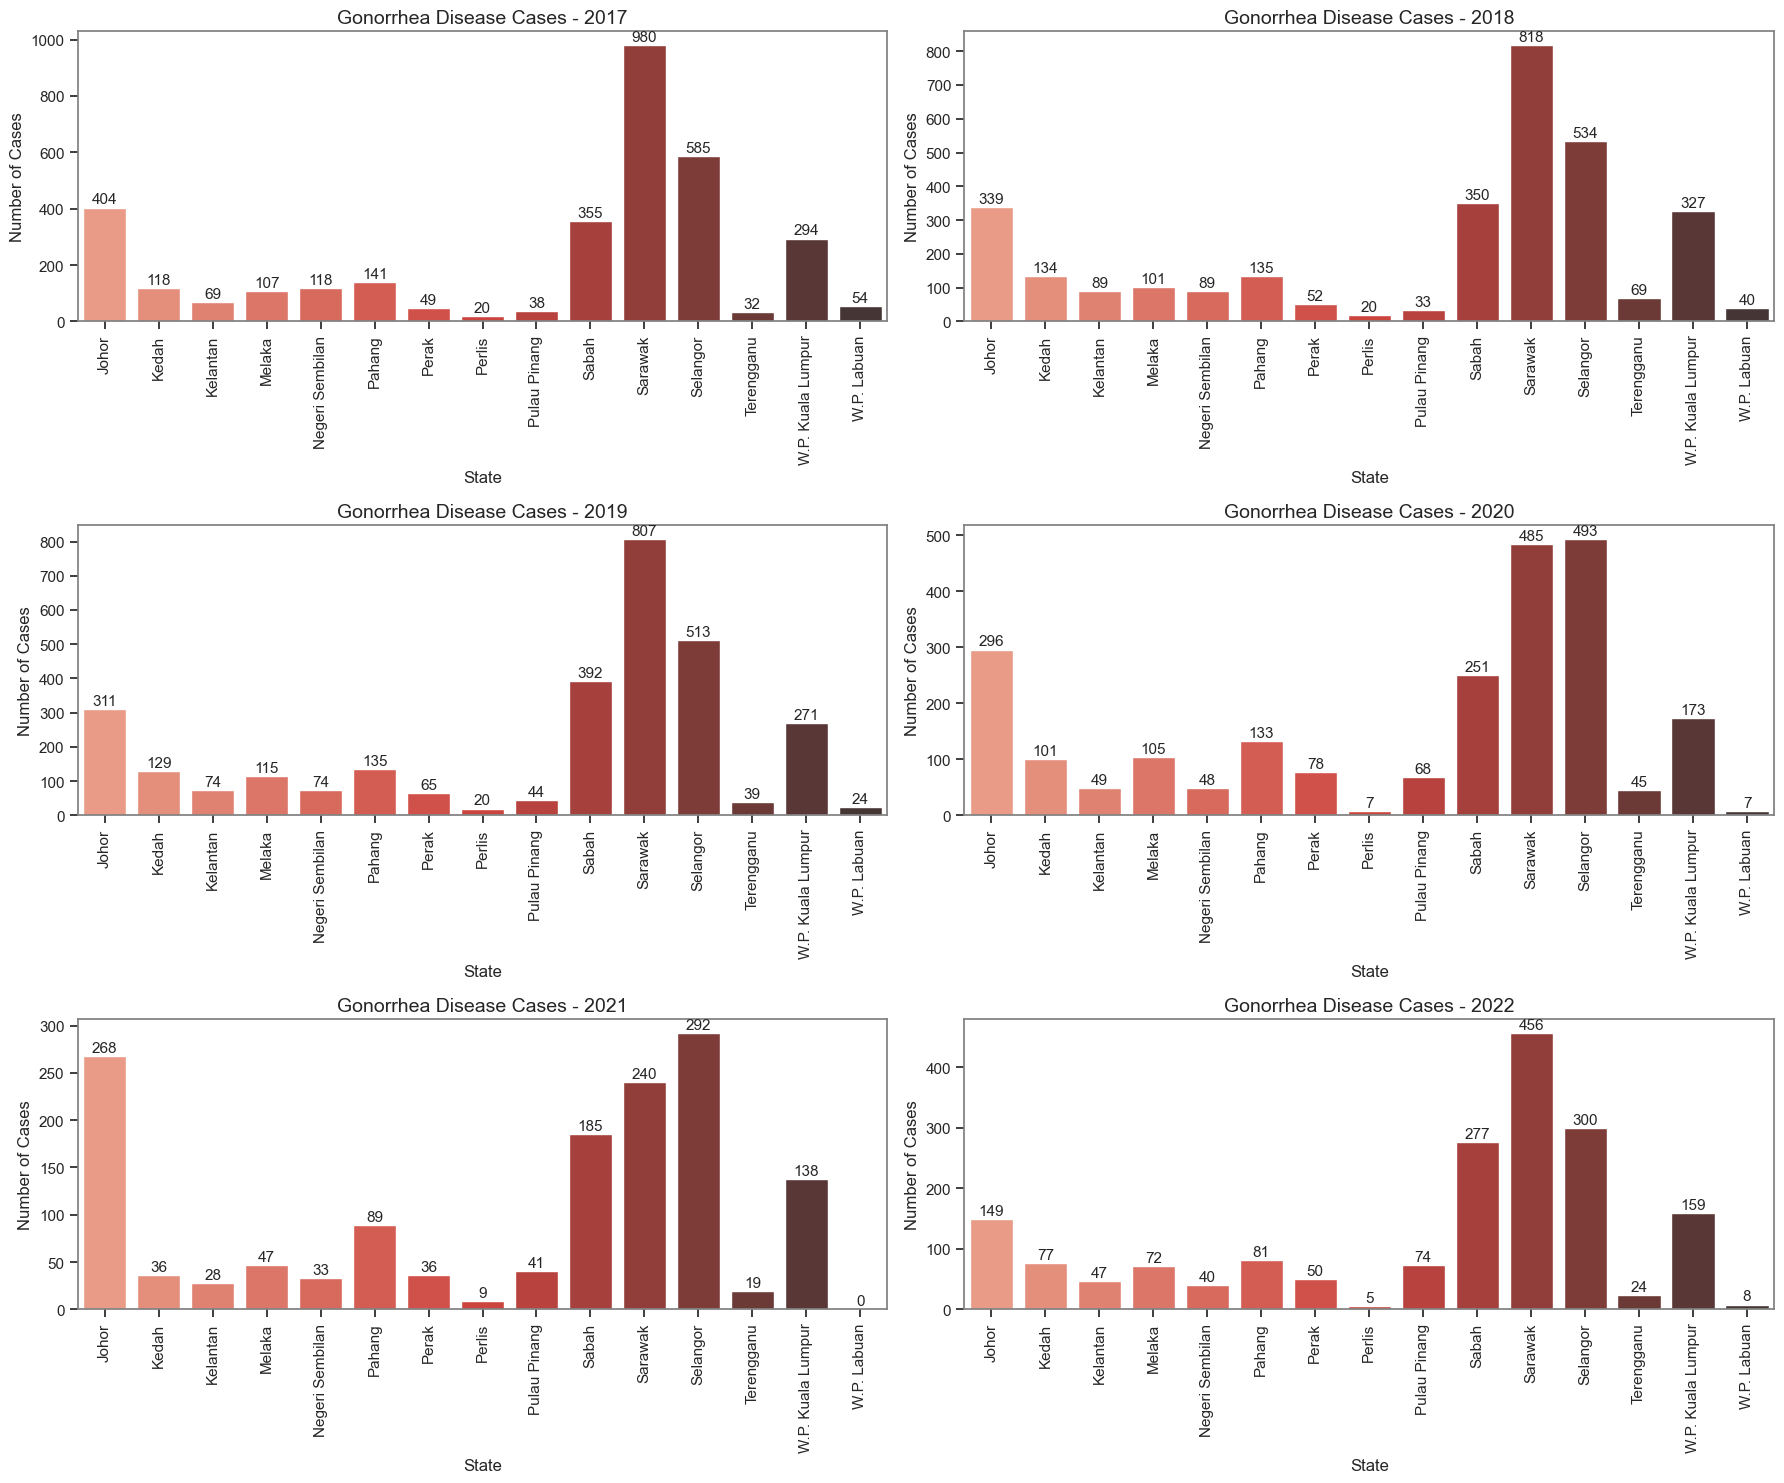

In [18]:
gonorrhea = df[(df['state'] != 'Malaysia') & (df['disease'] == 'gonorrhea')]

# Ensure consistent style
sns.set(style="ticks")

# Define the years to visualize
years = [2017, 2018, 2019, 2020, 2021, 2022]

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

# Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = gonorrhea[gonorrhea['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_cases',
        ax=ax,
        palette='Reds_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'Gonorrhea Disease Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

# Adjust layout
plt.tight_layout()
plt.show()

#### **8.3 HIV Cases By State (2017 - 2022)**

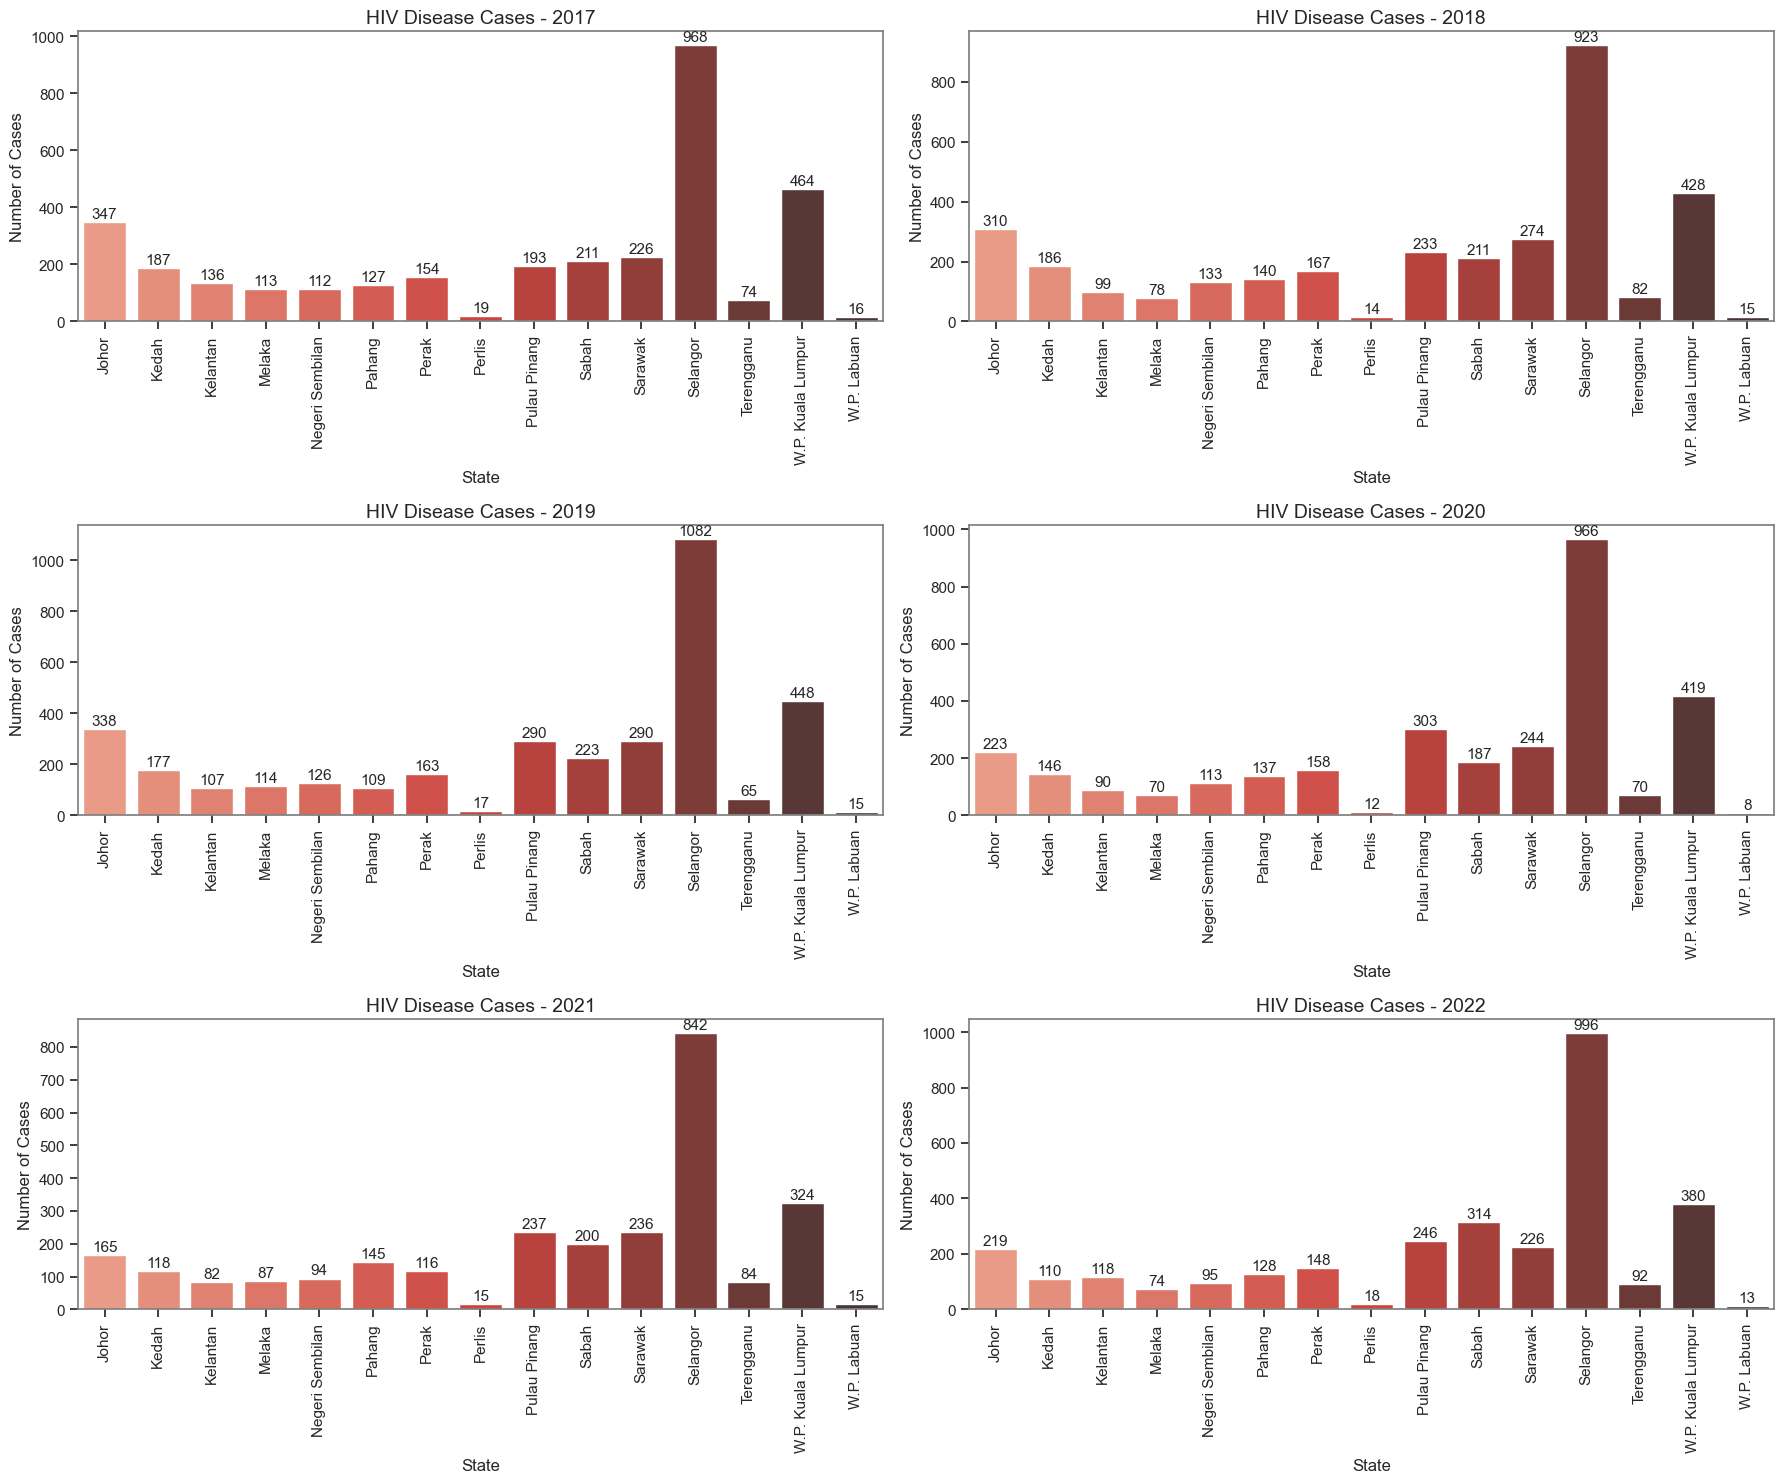

In [19]:
hiv = df[(df['state'] != 'Malaysia') & (df['disease'] == 'hiv')]

# Ensure consistent style
sns.set(style="ticks")

# Define the years to visualize
years = [2017, 2018, 2019, 2020, 2021, 2022]

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

# Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = hiv[hiv['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_cases',
        ax=ax,
        palette='Reds_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'HIV Disease Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

# Adjust layout
plt.tight_layout()
plt.show()

#### **8.4 Syphillis Cases By State (2017 - 2022)**

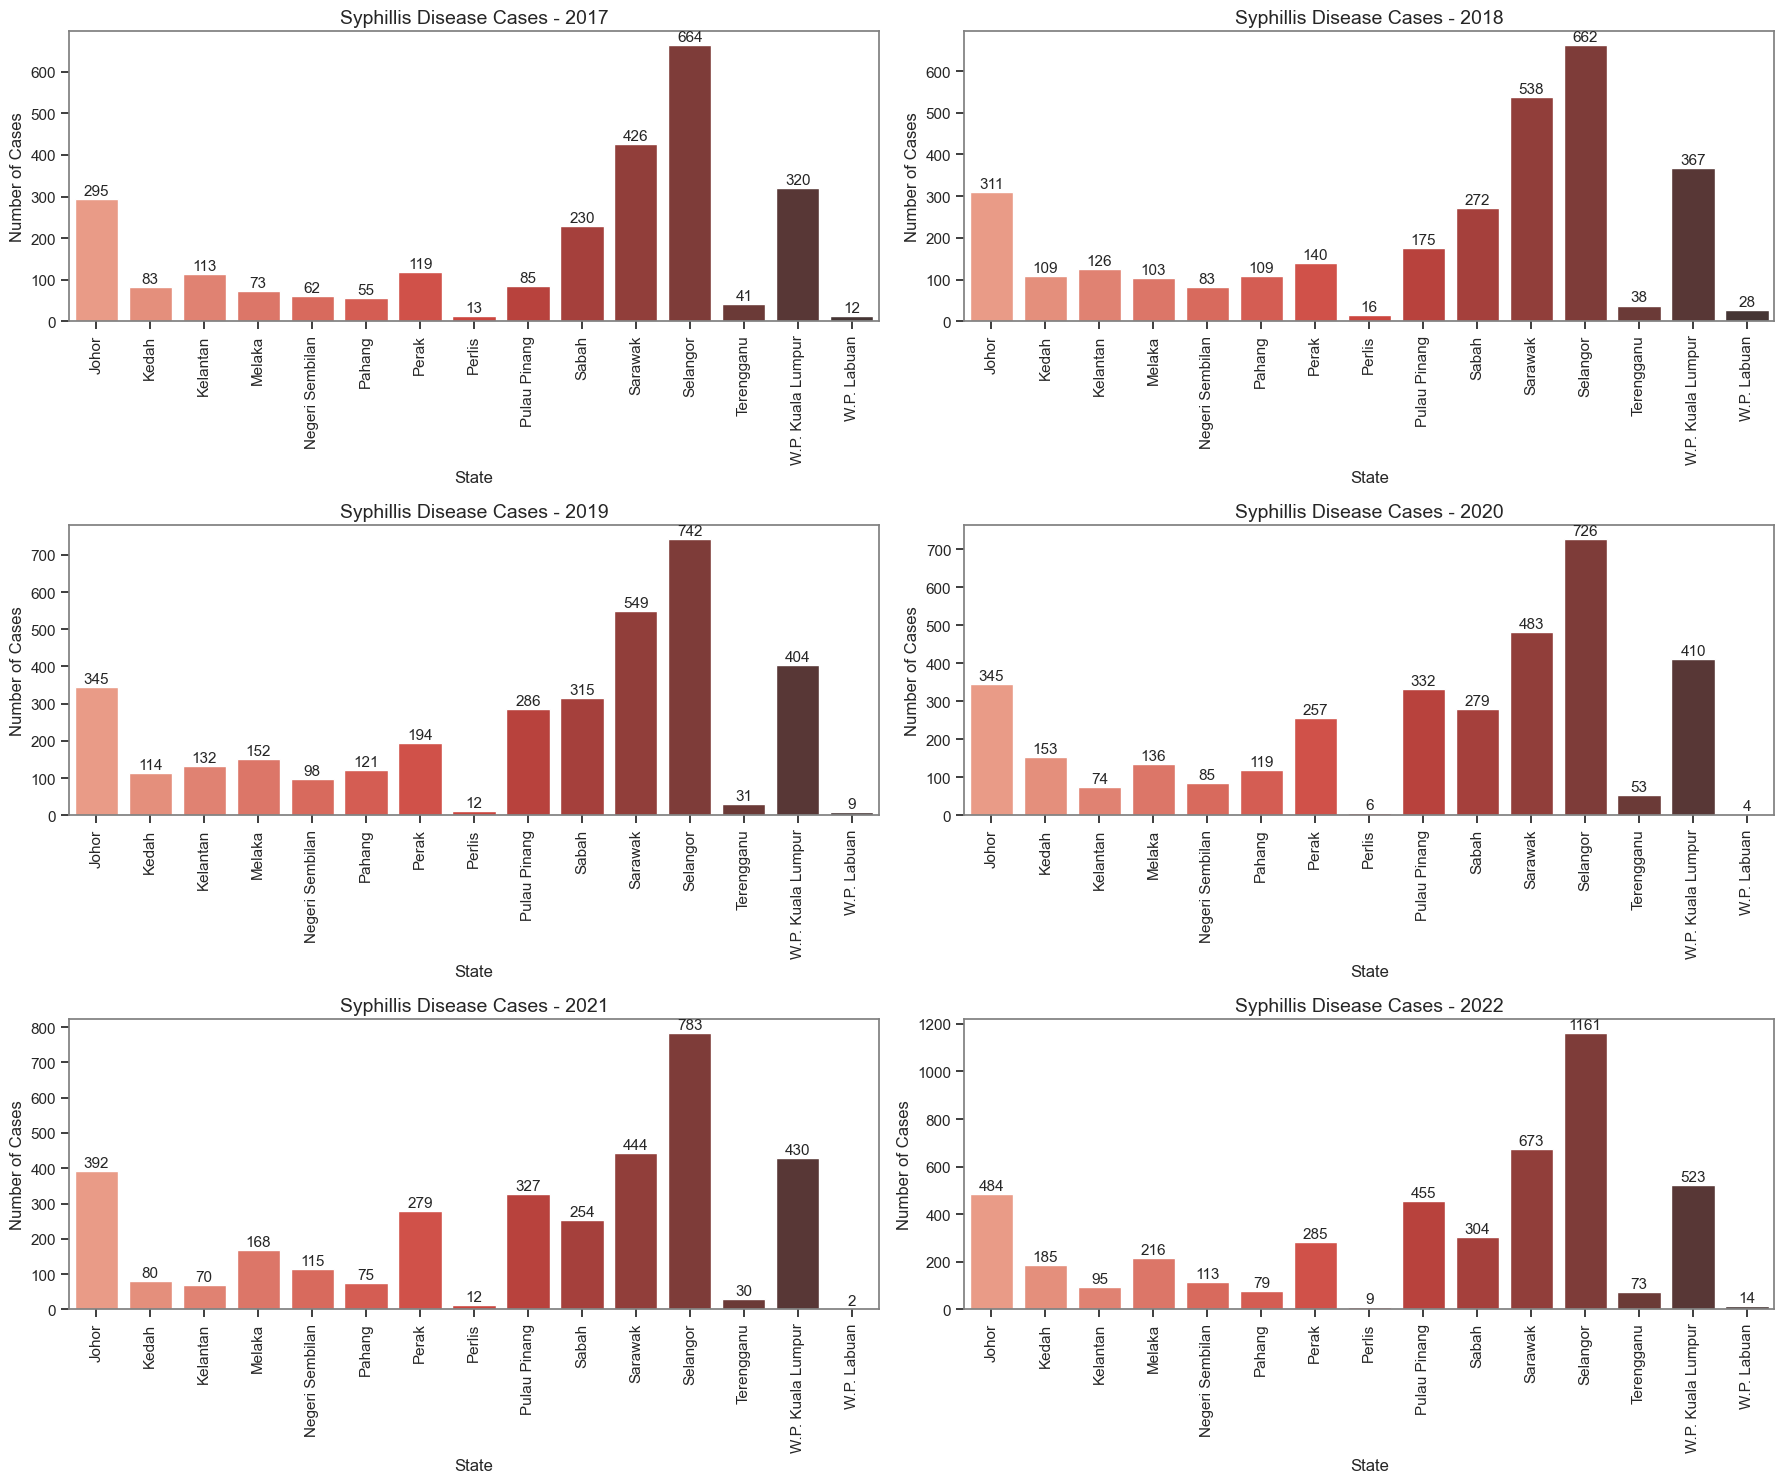

In [20]:
syphillis = df[(df['state'] != 'Malaysia') & (df['disease'] == 'syphillis')]

# Ensure consistent style
sns.set(style="ticks")

# Define the years to visualize
years = [2017, 2018, 2019, 2020, 2021, 2022]

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

# Loop through each year and plot on a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    data_year = syphillis[syphillis['year'] == year]
   
    # Plot the barplot
    barplot = sns.barplot(
        data=data_year,
        x='state',
        y='avg_cases',
        ax=ax,
        palette='Reds_d'
    )
    
    # Add value labels to the top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.0f', padding=0.75, fontsize=11)

    # Set titles and labels
    ax.set_title(f'Syphillis Disease Cases - {year}', fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Cases')
    ax.tick_params(axis='x', rotation=90)

    # Set all plot borders to gray
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

# Adjust layout
plt.tight_layout()
plt.show()